## Analyse Israel vaccine efficacy

In [1]:
import pandas as pd
import sys
sys.path.append("../")
import numpy as np
pd.set_option('display.max_rows', 500)
from datetime import datetime, timedelta
from utils import createXYPlot, get_efficacy
import subprocess
from functools import reduce

#### Download data manyally from put it in ./data (could not find an automated way)
https://data.gov.il/dataset/covid-19/resource/8a51c65b-f95a-4fb8-bd97-65f47109f41f/download/event-among-vaccinated-25.csv

In [2]:
df=pd.read_csv("./data/event-among-vaccinated-25.csv")
df["event_2nd_dose"] = df["event_after_2nd_dose"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["event_1st_dose"] = df["event_after_1st_dose"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["event_no_vax"] = df["event_for_not_vaccinated"].apply(lambda x: 4.0 if x == "<5" else float(x))
df["first_day"] = df["Week"].apply(lambda x: x.split(" - ")[0])
df["last_day"] = df["Week"].apply(lambda x: x.split(" - ")[1])
df=df.fillna(0)
df["over_60"]=df["Age_group"].apply(lambda x: "over_60" if x in ('60-69','70-79','80-89','90+') else "under_60")
df = df.rename(columns={"Age_group":"age_group",
                        "Week":"week",
                       "Type_of_event":"type_of_event"})
df = df[["week","first_day","last_day","age_group","over_60","type_of_event","event_1st_dose","event_2nd_dose","event_no_vax"]]

In [3]:
df

week   first_day    last_day age_group   over_60  \
0    2020-12-20 - 2020-12-26  2020-12-20  2020-12-26      0-19  under_60   
1    2020-12-20 - 2020-12-26  2020-12-20  2020-12-26      0-19  under_60   
2    2020-12-20 - 2020-12-26  2020-12-20  2020-12-26     20-29  under_60   
3    2020-12-20 - 2020-12-26  2020-12-20  2020-12-26     20-29  under_60   
4    2020-12-20 - 2020-12-26  2020-12-20  2020-12-26     30-39  under_60   
..                       ...         ...         ...       ...       ...   
517  2021-07-04 - 2021-07-10  2021-07-04  2021-07-10     70-79   over_60   
518  2021-07-04 - 2021-07-10  2021-07-04  2021-07-10     80-89   over_60   
519  2021-07-04 - 2021-07-10  2021-07-04  2021-07-10     80-89   over_60   
520  2021-07-04 - 2021-07-10  2021-07-04  2021-07-10       90+   over_60   
521  2021-07-04 - 2021-07-10  2021-07-04  2021-07-10       90+   over_60   

       type_of_event  event_1st_dose  event_2nd_dose  event_no_vax  
0    Hospitalization             0.0             0.0          56.0  
1              Death             0.0             0.0           0.0  
2    Hospitalization             0.0             0.0          50.0  
3              Death             0.0             0.0           4.0  
4    Hospitalization             0.0             0.0          79.0  
..               ...             ...             ...           ...  
517            Death             0.0             4.0           0.0  
518  Hospitalization             0.0             9.0           4.0  
519            Death             0.0             4.0           0.0  
520  Hospitalization             0.0             4.0           0.0  
521            Death             0.0             0.0           0.0  

[522 rows x 9 columns]

In [4]:
last_day=str(np.max(df["last_day"]))
print(f"Last available data: {last_day}")

Last available data: 2021-07-10


In [5]:
print("Creating plot folder")
plot_folder = f"./plots/{last_day}"
subprocess.run(f"mkdir -p {plot_folder}", shell=True)

Creating plot folder


CompletedProcess(args='mkdir -p ./plots/2021-07-10', returncode=0)

In [6]:
types = df.type_of_event.unique()
print(f"Types of event: {types}")

Types of event: ['Hospitalization' 'Death']


In [7]:
df_events = {}
for event in types:
    df_events[event] = df[df.type_of_event==event].groupby(["week", "first_day", "last_day"]).agg(
        event_1st_dose=("event_1st_dose","sum"),
        event_2nd_dose=("event_2nd_dose","sum"),
        event_no_vax=("event_no_vax","sum"),
    ).reset_index() 

In [8]:
display(df_events["Hospitalization"].head(10))
display(df_events["Hospitalization"].tail(10))

week   first_day    last_day  event_1st_dose  \
0  2020-12-20 - 2020-12-26  2020-12-20  2020-12-26            12.0   
1  2020-12-27 - 2021-01-02  2020-12-27  2021-01-02            83.0   
2  2021-01-03 - 2021-01-09  2021-01-03  2021-01-09           438.0   
3  2021-01-10 - 2021-01-16  2021-01-10  2021-01-16           694.0   
4  2021-01-17 - 2021-01-23  2021-01-17  2021-01-23           584.0   
5  2021-01-24 - 2021-01-30  2021-01-24  2021-01-30           340.0   
6  2021-01-31 - 2021-02-06  2021-01-31  2021-02-06           260.0   
7  2021-02-07 - 2021-02-13  2021-02-07  2021-02-13           185.0   
8  2021-02-14 - 2021-02-20  2021-02-14  2021-02-20           139.0   
9  2021-02-21 - 2021-02-27  2021-02-21  2021-02-27           161.0   

   event_2nd_dose  event_no_vax  
0             0.0        1041.0  
1             0.0        1181.0  
2             0.0        1256.0  
3             4.0        1119.0  
4            46.0        1114.0  
5           147.0         992.0  
6           166.0        1080.0  
7           110.0        1000.0  
8            89.0         862.0  
9            81.0         817.0

week   first_day    last_day  event_1st_dose  \
19  2021-05-02 - 2021-05-08  2021-05-02  2021-05-08            12.0   
20  2021-05-09 - 2021-05-15  2021-05-09  2021-05-15            12.0   
21  2021-05-16 - 2021-05-22  2021-05-16  2021-05-22             0.0   
22  2021-05-23 - 2021-05-29  2021-05-23  2021-05-29            16.0   
23  2021-05-30 - 2021-06-05  2021-05-30  2021-06-05             4.0   
24  2021-06-06 - 2021-06-12  2021-06-06  2021-06-12            12.0   
25  2021-06-13 - 2021-06-19  2021-06-13  2021-06-19             8.0   
26  2021-06-20 - 2021-06-26  2021-06-20  2021-06-26            12.0   
27  2021-06-27 - 2021-07-03  2021-06-27  2021-07-03             8.0   
28  2021-07-04 - 2021-07-10  2021-07-04  2021-07-10            12.0   

    event_2nd_dose  event_no_vax  
19            20.0          39.0  
20            20.0          32.0  
21            24.0          32.0  
22            24.0          28.0  
23            24.0          29.0  
24            20.0          20.0  
25            28.0          12.0  
26            16.0          32.0  
27            37.0          36.0  
28            63.0          32.0

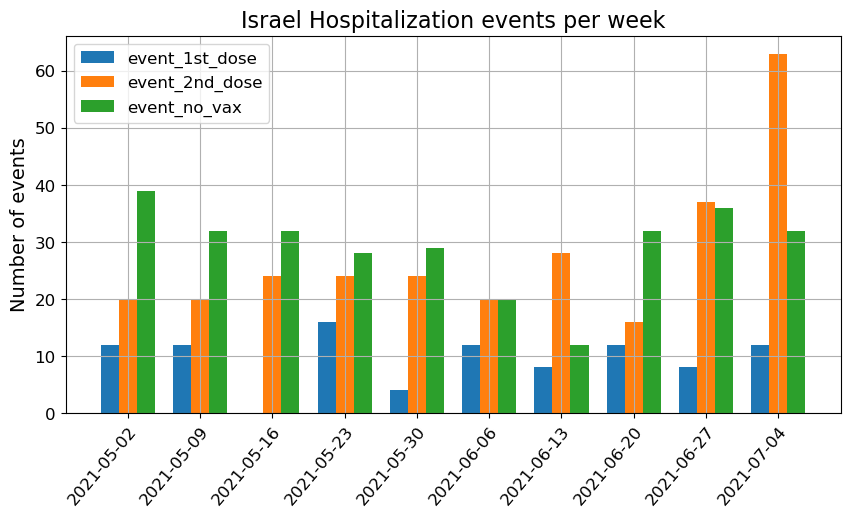

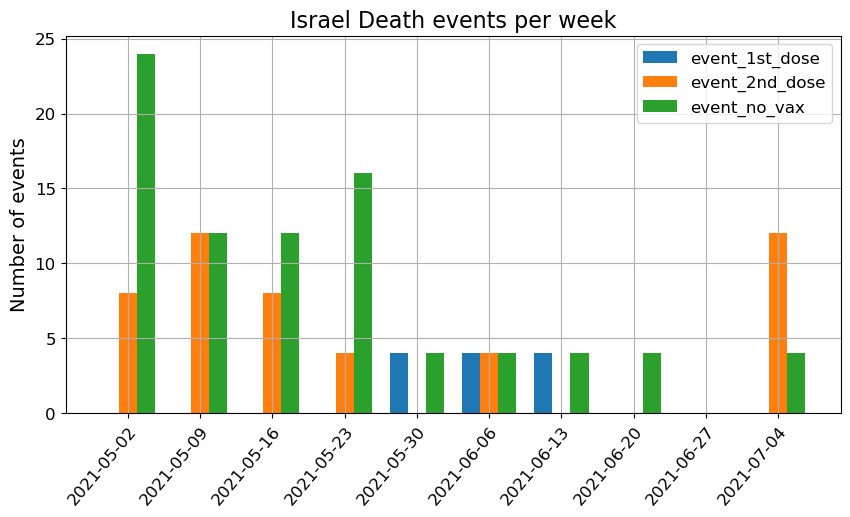

In [9]:
for event in types:
    createXYPlot(df_events[event],
                 y=["event_1st_dose",
                    "event_2nd_dose",
                    "event_no_vax"],
                 today=last_day,
                 plots_folder=plot_folder,
                 x="first_day",
                 linewidth=2,
                 start_date="2021-05-01",
                 days_interval=1,
                 bar=True,
                 alpha=1,
                 bar_width=0.25,
                 bar_start=[-1,0,1],
                 title=f"Israel {event} events per week",
                 xtitle=None,
                 ytitle="Number of events",
                 savename=f"Israel_{event}_events_vax"
                )

### Split by age groups

In [10]:
df_events_age = {}
for event in types:
    df_events_age[event] = df[df.type_of_event==event].groupby(["week", "first_day", "last_day", "age_group","over_60"]).agg(
        event_1st_dose=("event_1st_dose","sum"),
        event_2nd_dose=("event_2nd_dose","sum"),
        event_no_vax=("event_no_vax","sum"),
    ).reset_index()


In [11]:
age_groups = sorted(df["age_group"].unique())
print(f"Age groups: {age_groups}")

Age groups: ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']


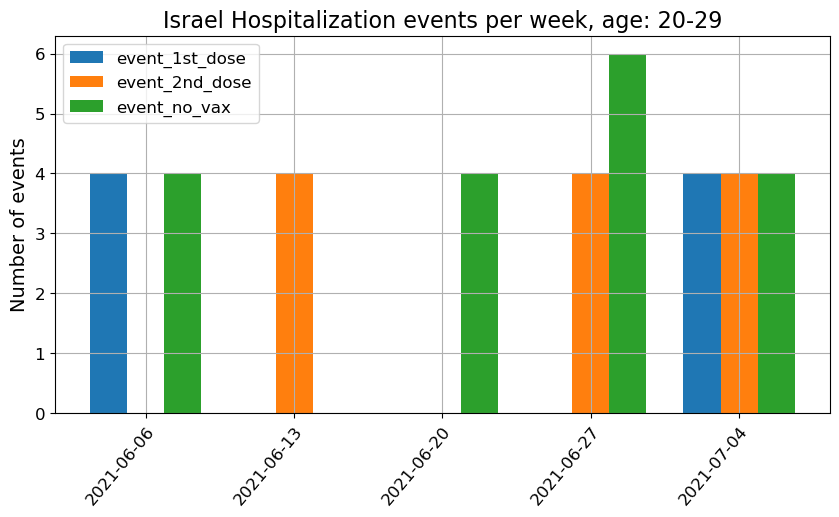

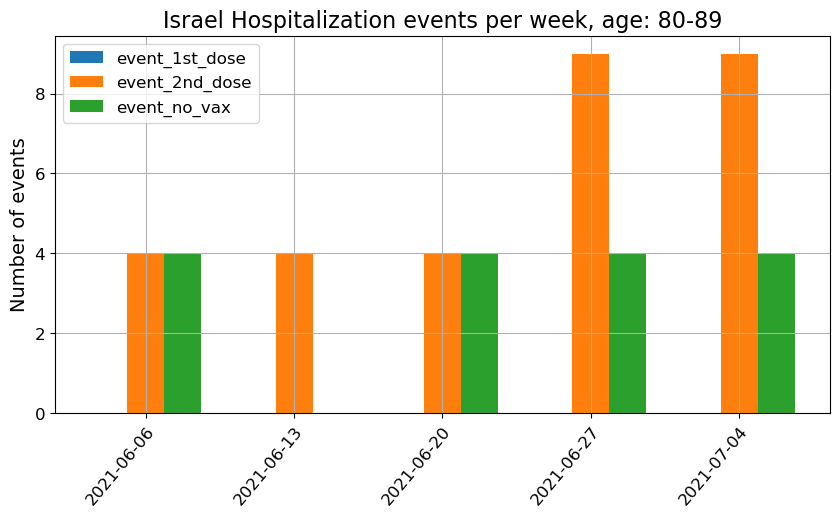

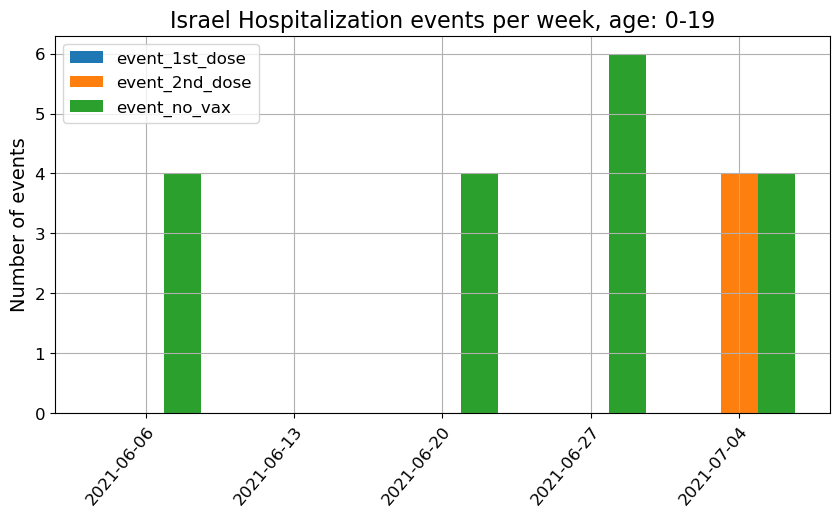

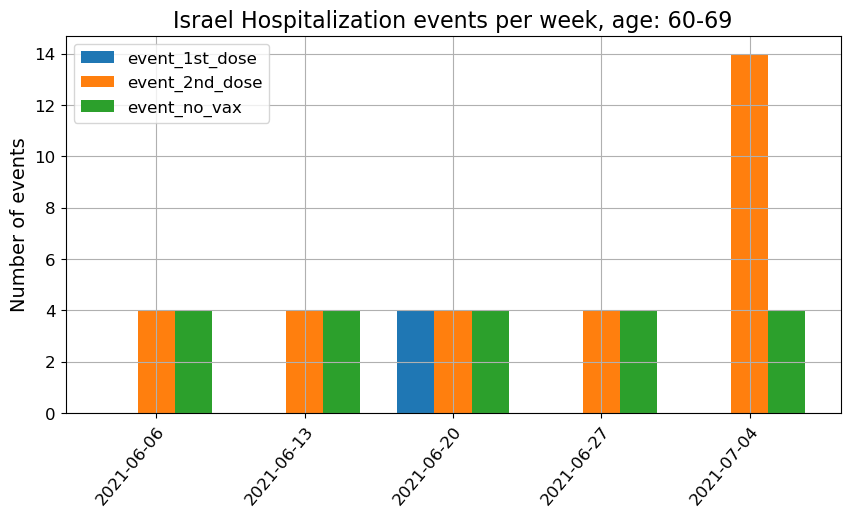

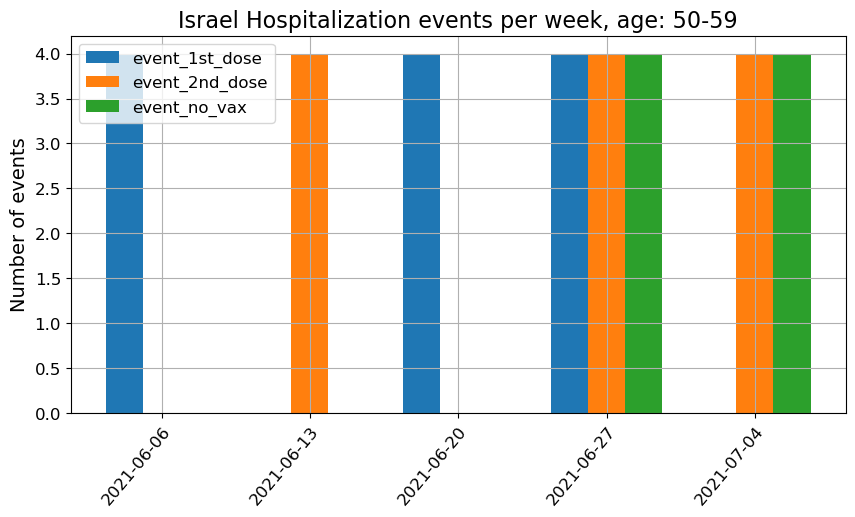

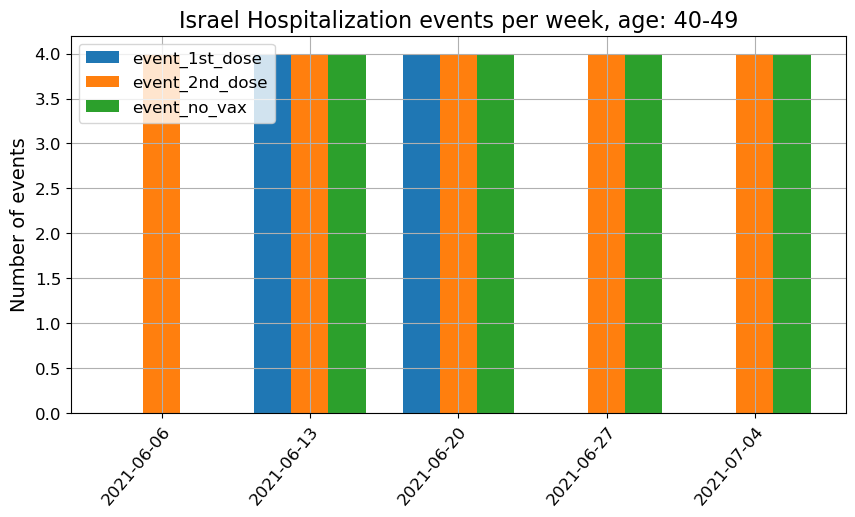

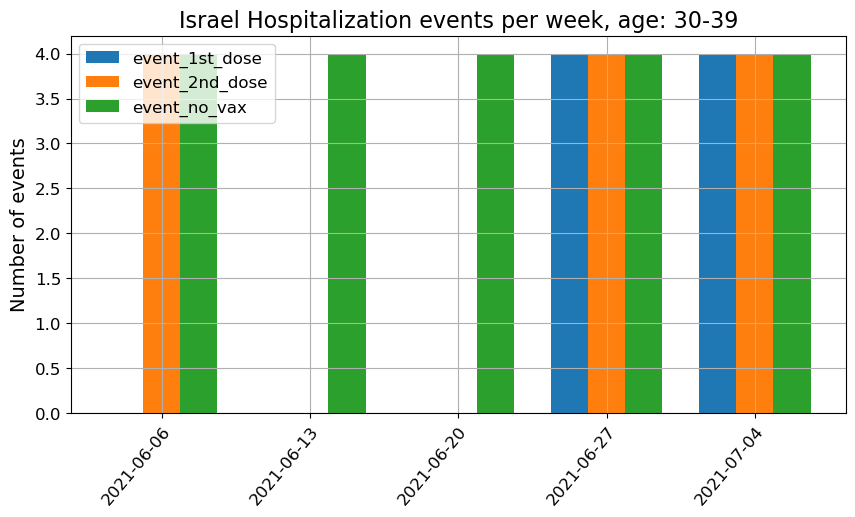

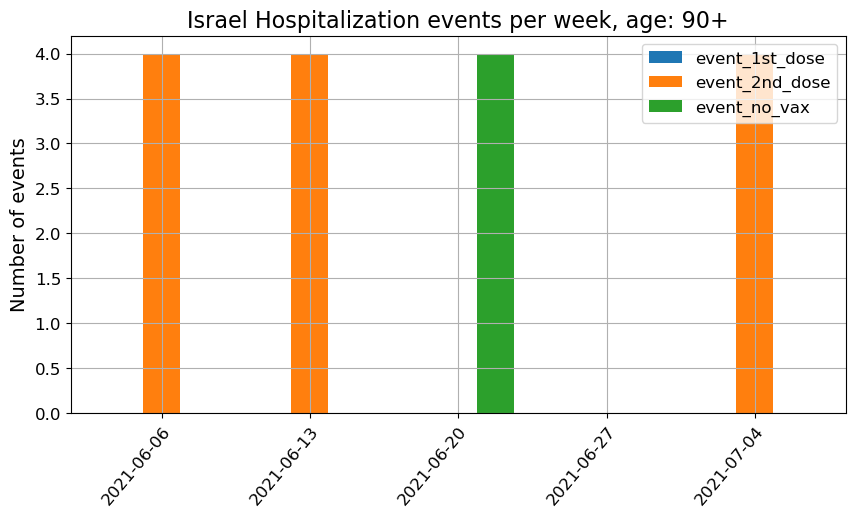

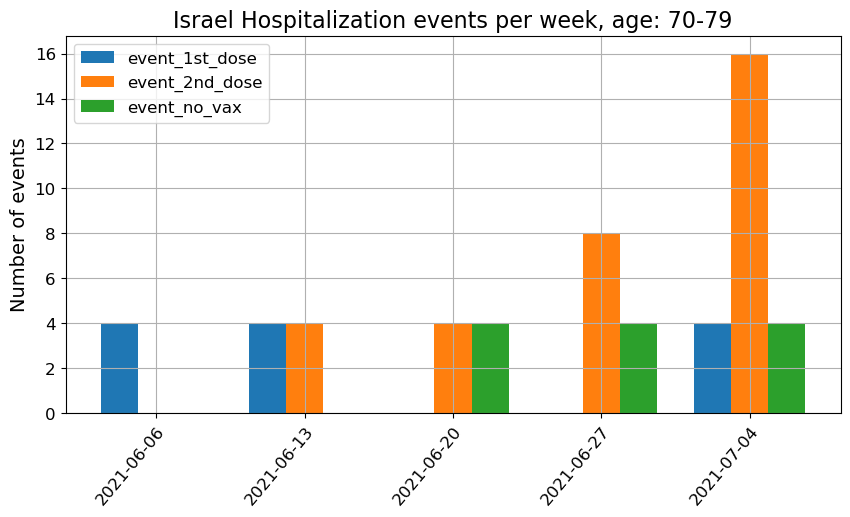

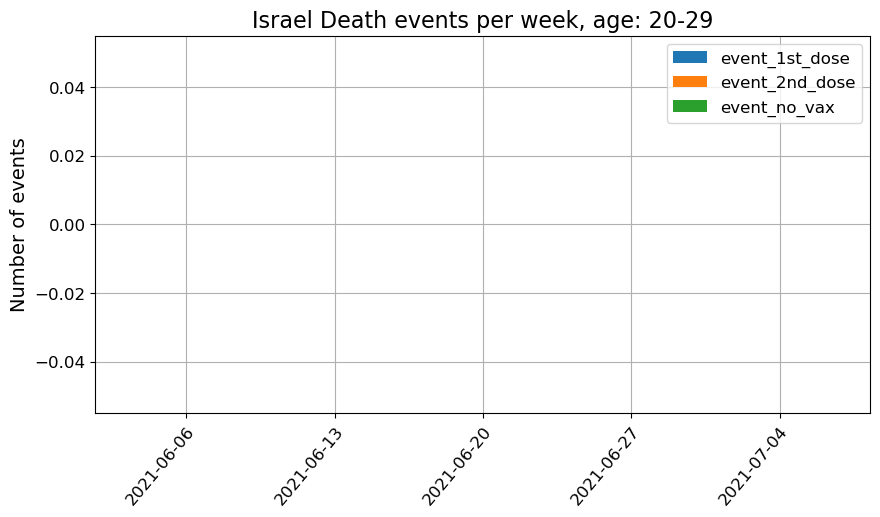

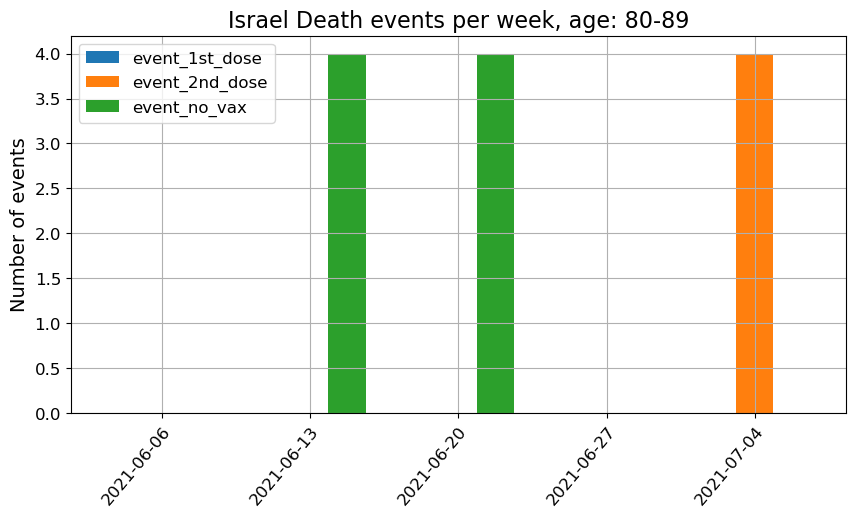

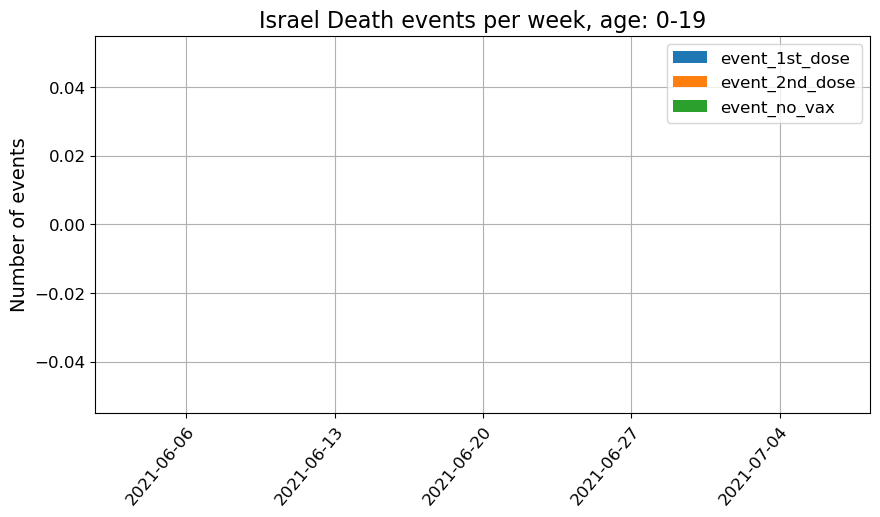

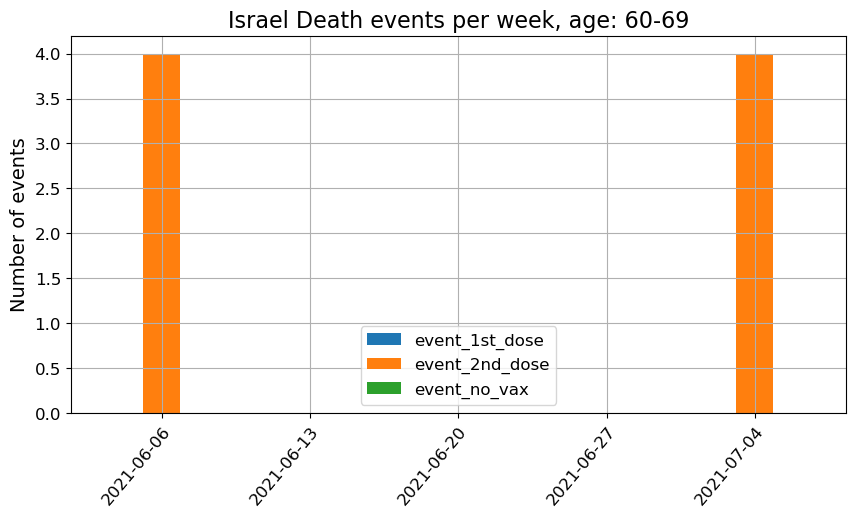

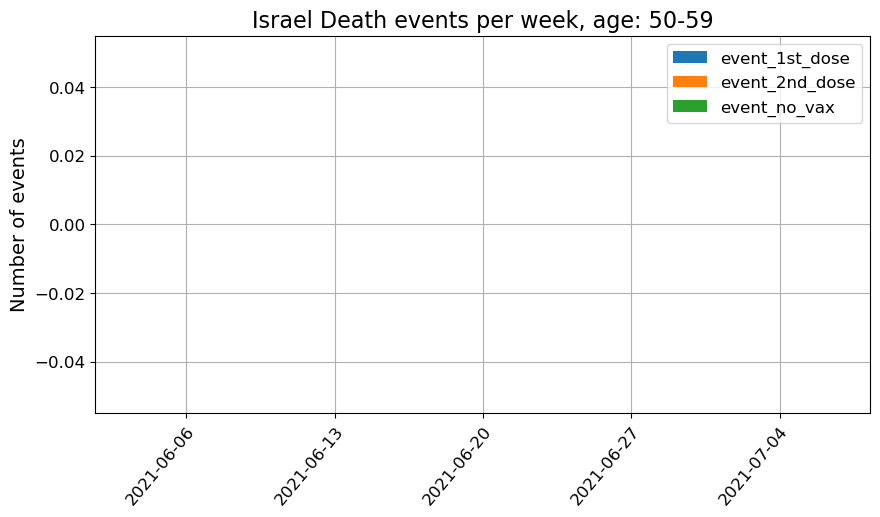

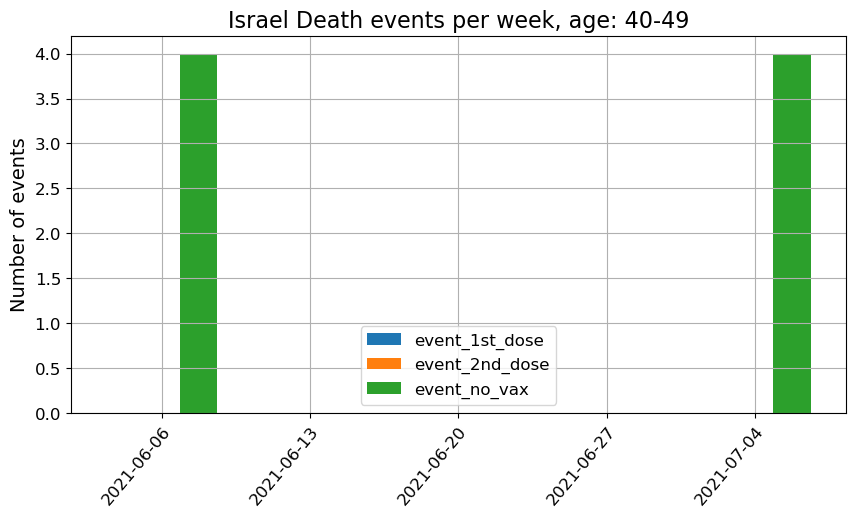

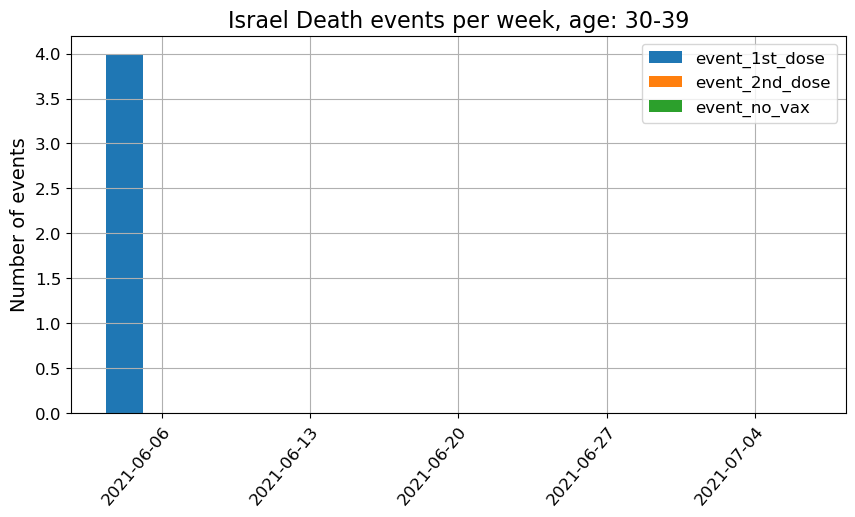

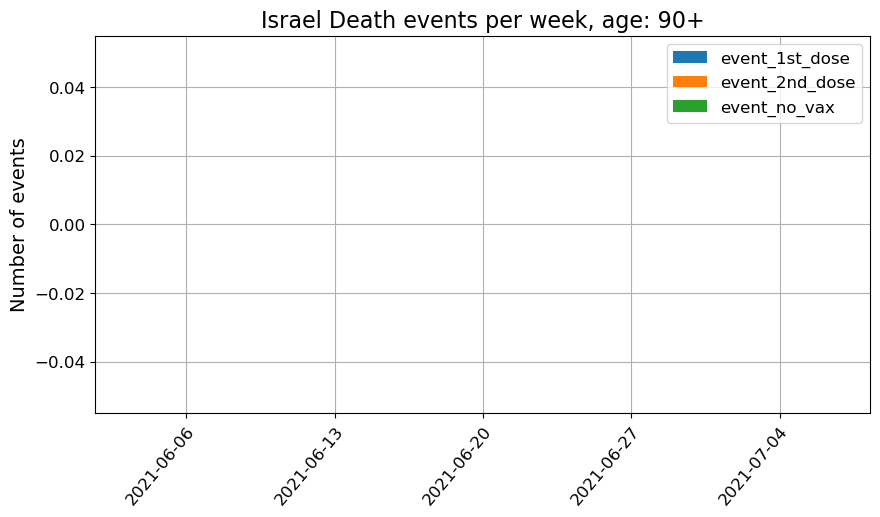

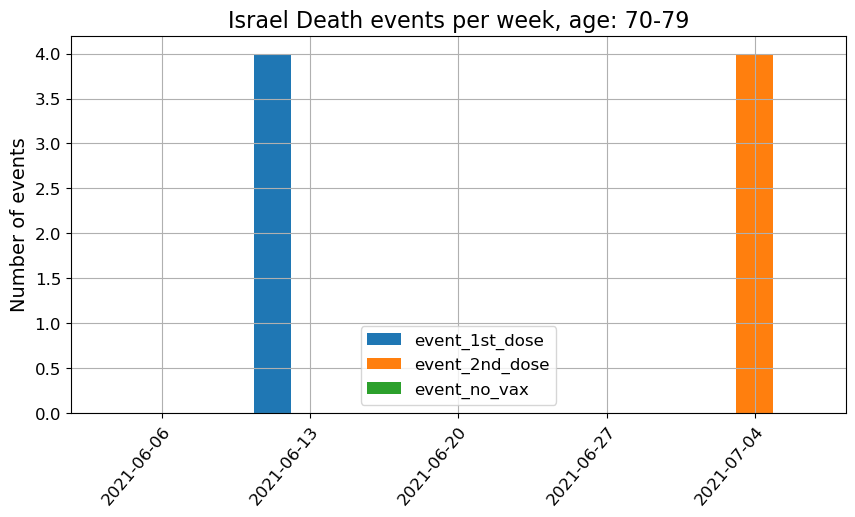

In [45]:
for event in types:
    for age in age_groups:
        createXYPlot(df_events_age[event][df_events_age[event]["age_group"]==age],
                 y=["event_1st_dose",
                    "event_2nd_dose",
                    "event_no_vax"],
                 today=last_day,
                 plots_folder=plot_folder,
                 x="first_day",
                 linewidth=2,
                 start_date="2021-06-01",
                 days_interval=1,
                 bar=True,
                 alpha=1,
                 bar_width=0.25,
                 bar_start=[-1,0,1],
                 title=f"Israel {event} events per week, age: {age}",
                 xtitle=None,
                 ytitle="Number of events",
                 savename=f"Israel_{event}_events_{age.replace('-','_')}_vax")

### Vaccinations per day - age_group

https://data.gov.il/dataset/covid-19/resource/57410611-936c-49a6-ac3c-838171055b1f/download/vaccinated-per-day-2021-07-13.csv


In [13]:
df_vax_age = pd.read_csv("./data/vaccinated-per-day-2021-07-13.csv")

In [14]:
df_vax_age["week"] = ((pd.to_datetime(df_vax_age["VaccinationDate"]) - pd.to_datetime("2020-12-20")).dt.days / 7).astype(int)
df_vax_age["over_60"] = df_vax_age["age_group"].apply(lambda x: "over_60" if x in ('60-69','70-79','80-89','90+') else "under_60")
df_vax_age["first_dose"] = df_vax_age["first_dose"].apply(lambda x: int(x.replace("<","")) - 1 if "<" in x else int(x))
df_vax_age["second_dose"] = df_vax_age["second_dose"].apply(lambda x: int(x.replace("<","")) - 1 if "<" in x else int(x))

In [15]:
df_vax_age

VaccinationDate age_group  first_dose  second_dose  week   over_60
0         2020-12-20     20-29         392            0     0  under_60
1         2020-12-20     80-89          93            0     0   over_60
2         2020-12-20      0-19          21            0     0  under_60
3         2020-12-20     60-69        1516            0     0   over_60
4         2020-12-20     50-59        1786            0     0  under_60
...              ...       ...         ...          ...   ...       ...
1836      2021-07-13     70-79          31           27    29   over_60
1837      2021-07-13       90+          14           14    29   over_60
1838      2021-07-13     80-89          17           16    29   over_60
1839      2021-07-13      0-19        1501         4296    29  under_60
1840      2021-07-13     20-29         533          360    29  under_60

[1841 rows x 6 columns]

#### Create grid of dates in case some are missing

In [16]:
min_yyyy_mm_dd = datetime.strptime(np.min(df_vax_age["VaccinationDate"]),"%Y-%m-%d")
max_yyyy_mm_dd = datetime.strptime(np.max(df_vax_age["VaccinationDate"]),"%Y-%m-%d")
print(f"min day: {min_yyyy_mm_dd}")
print(f"max day: {max_yyyy_mm_dd}")
all_yyy_mm_dd = pd.DataFrame([str(i.date()) for i in pd.date_range(min_yyyy_mm_dd, max_yyyy_mm_dd,freq='d')], columns=["VaccinationDate"])
age_groups = df_vax_age["age_group"].unique()
all_age_groups = pd.DataFrame(age_groups,columns=["age_group"])

min day: 2020-12-20 00:00:00
max day: 2021-07-13 00:00:00


In [17]:
all_yyy_mm_dd["key"]=0
all_age_groups["key"]=0
all_yyy_mm_dd=all_yyy_mm_dd.set_index("key")
all_age_groups=all_age_groups.set_index("key")
df_grid=all_yyy_mm_dd.join(all_age_groups).sort_values(by=["VaccinationDate","age_group"]).set_index(["VaccinationDate","age_group"])

In [18]:
display(df_grid.head(10))
display(df_grid.tail(10))

Empty DataFrame
Columns: []
Index: [(2020-12-20, 0-19), (2020-12-20, 20-29), (2020-12-20, 30-39), (2020-12-20, 40-49), (2020-12-20, 50-59), (2020-12-20, 60-69), (2020-12-20, 70-79), (2020-12-20, 80-89), (2020-12-20, 90+), (2020-12-21, 0-19)]

Empty DataFrame
Columns: []
Index: [(2021-07-12, 90+), (2021-07-13, 0-19), (2021-07-13, 20-29), (2021-07-13, 30-39), (2021-07-13, 40-49), (2021-07-13, 50-59), (2021-07-13, 60-69), (2021-07-13, 70-79), (2021-07-13, 80-89), (2021-07-13, 90+)]

In [19]:
df_vax_age = df_grid.join(df_vax_age.set_index(["VaccinationDate","age_group"])).reset_index().fillna({"first_dose":0, "second_dose":0})
df_vax_age["week"] = ((pd.to_datetime(df_vax_age["VaccinationDate"]) - pd.to_datetime("2020-12-20")).dt.days / 7).astype(int)
df_vax_age["over_60"] = df_vax_age["age_group"].apply(lambda x: "over_60" if x in ('60-69','70-79','80-89','90+') else "under_60")
df_vax_age = df_vax_age.sort_values(by=["VaccinationDate","age_group"])

In [20]:
df_vax_age.tail(30)

VaccinationDate age_group  first_dose  second_dose  week   over_60
1824      2021-07-10     70-79        25.0         14.0    28   over_60
1825      2021-07-10     80-89        14.0          0.0    28   over_60
1826      2021-07-10       90+         0.0          0.0    28   over_60
1827      2021-07-11      0-19       505.0       1968.0    29  under_60
1828      2021-07-11     20-29       298.0        237.0    29  under_60
1829      2021-07-11     30-39       234.0        219.0    29  under_60
1830      2021-07-11     40-49       171.0        149.0    29  under_60
1831      2021-07-11     50-59       101.0         68.0    29  under_60
1832      2021-07-11     60-69        49.0         65.0    29   over_60
1833      2021-07-11     70-79        20.0         24.0    29   over_60
1834      2021-07-11     80-89        14.0         21.0    29   over_60
1835      2021-07-11       90+         0.0         14.0    29   over_60
1836      2021-07-12      0-19      1157.0       2679.0    29  under_60
1837      2021-07-12     20-29       447.0        295.0    29  under_60
1838      2021-07-12     30-39       261.0        213.0    29  under_60
1839      2021-07-12     40-49       213.0        133.0    29  under_60
1840      2021-07-12     50-59       128.0         88.0    29  under_60
1841      2021-07-12     60-69        70.0         52.0    29   over_60
1842      2021-07-12     70-79        23.0         26.0    29   over_60
1843      2021-07-12     80-89        14.0         14.0    29   over_60
1844      2021-07-12       90+        14.0         14.0    29   over_60
1845      2021-07-13      0-19      1501.0       4296.0    29  under_60
1846      2021-07-13     20-29       533.0        360.0    29  under_60
1847      2021-07-13     30-39       340.0        224.0    29  under_60
1848      2021-07-13     40-49       209.0        149.0    29  under_60
1849      2021-07-13     50-59       136.0        101.0    29  under_60
1850      2021-07-13     60-69        63.0         51.0    29   over_60
1851      2021-07-13     70-79        31.0         27.0    29   over_60
1852      2021-07-13     80-89        17.0         16.0    29   over_60
1853      2021-07-13       90+        14.0         14.0    29   over_60

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


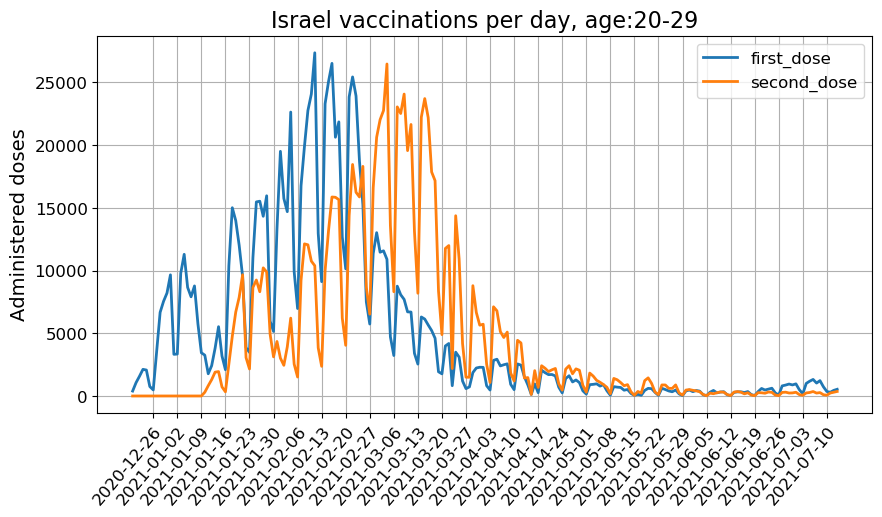

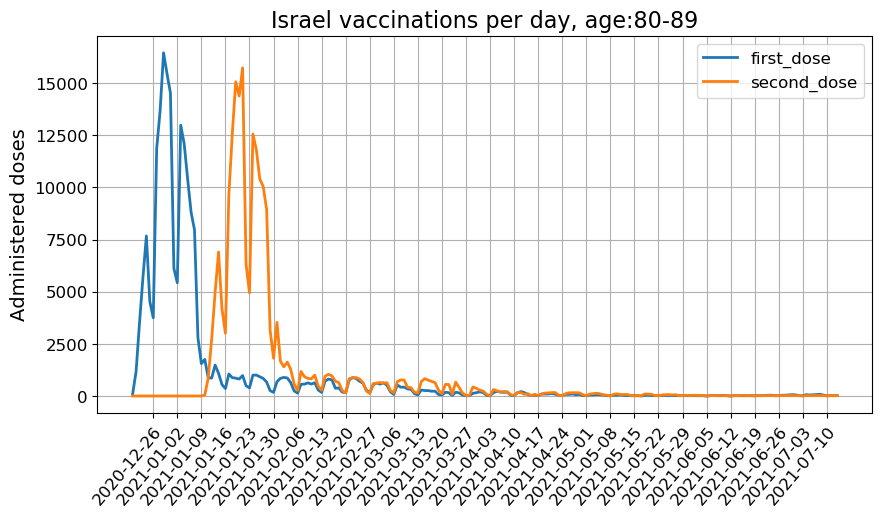

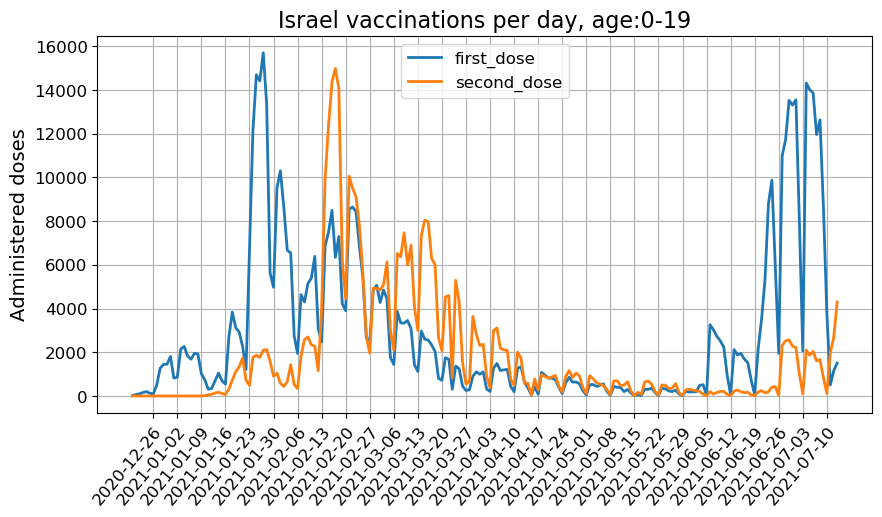

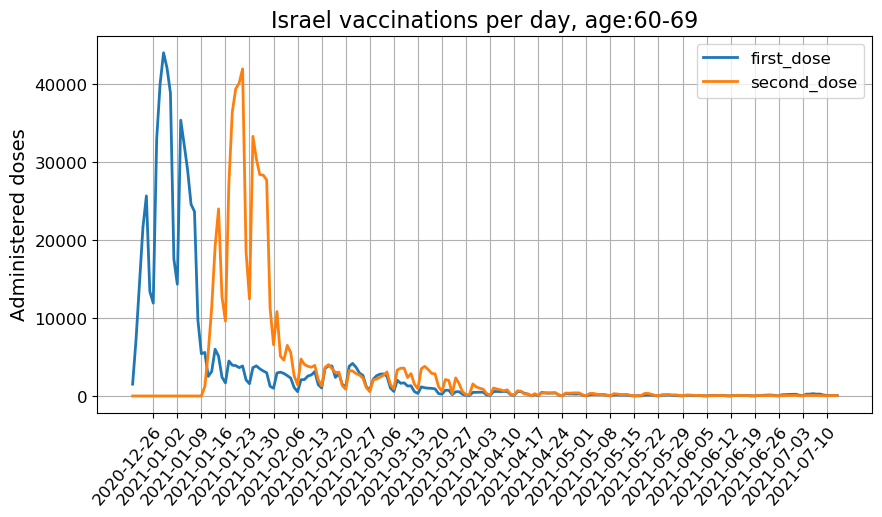

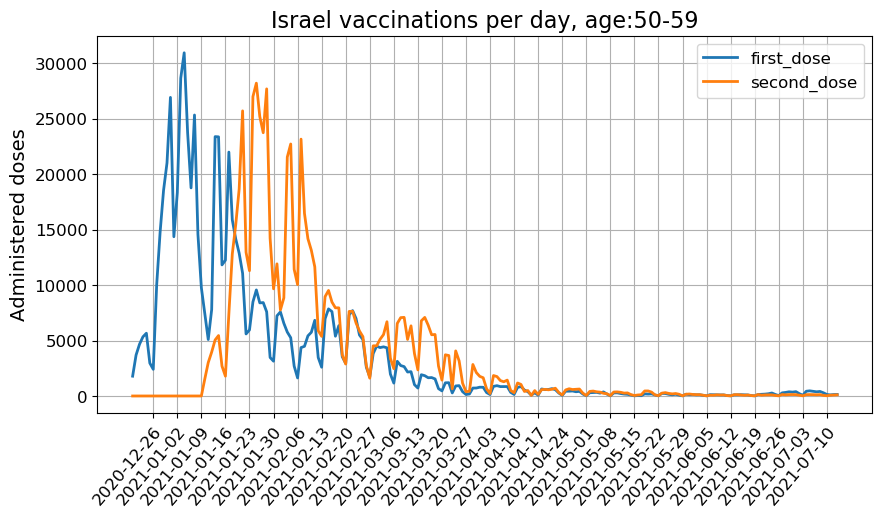

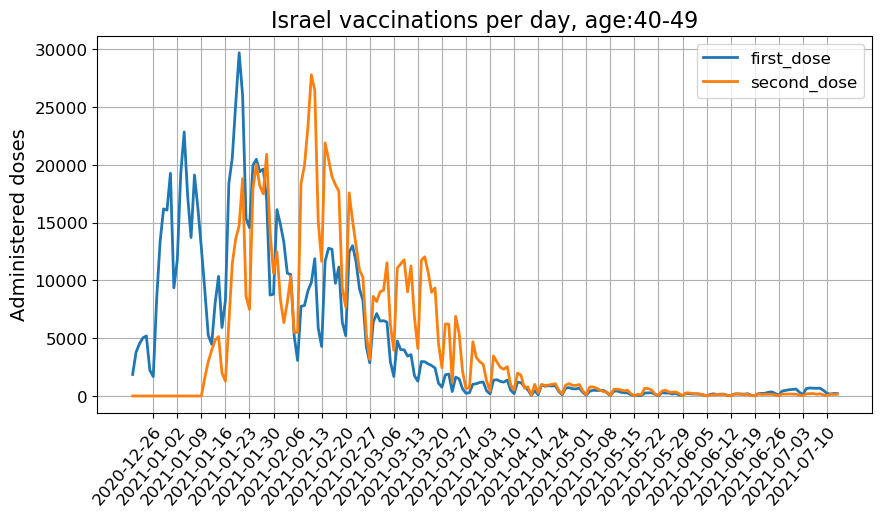

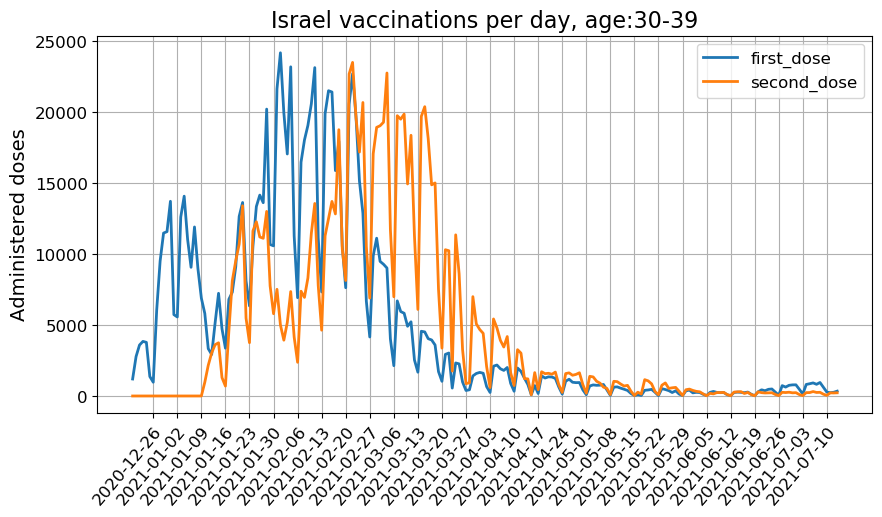

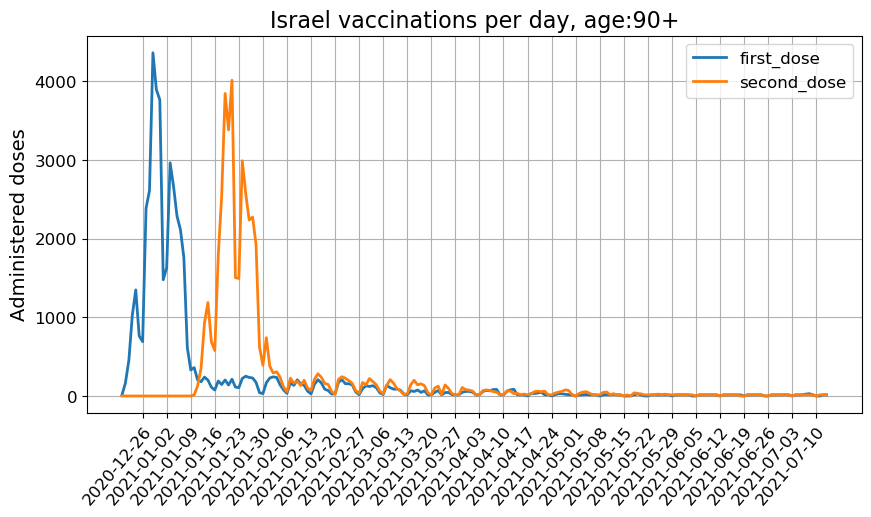

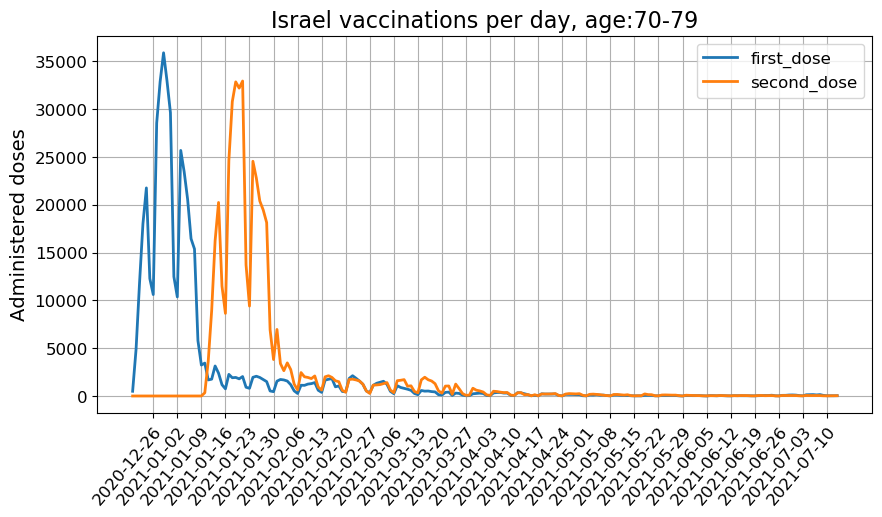

In [21]:
for age in age_groups:
    createXYPlot(df_vax_age[df_vax_age.age_group==age],
             y=["first_dose","second_dose"],
             today="",
             plots_folder=plot_folder,
             x="VaccinationDate",
             linewidth=2,
             start_date="2020-12-01",
             days_interval=7,
             bar=False,
             alpha=1,
             bar_width=0.3,
             bar_start=[-1,0,1],
             title=f"Israel vaccinations per day, age:{age}",
             savename=f"Israel_vaccinations_{age}",
             ytitle="Administered doses"
            )

### Aggregate by week

In [22]:
df_vax_age_week = df_vax_age.groupby(["week","age_group","over_60"]).agg(first_day=("VaccinationDate","min"),
                                                               last_day=("VaccinationDate","max"),
                                                               first_dose=("first_dose","sum"),
                                                               second_dose=("second_dose","sum")
                                                              ).reset_index()

df_vax_age_week["week"] = df_vax_age_week["first_day"] + " - " + df_vax_age_week["last_day"]
df_vax_age_week = df_vax_age_week.sort_values(by=["week","age_group"])

In [23]:
df_vax_age_week

week age_group   over_60   first_day    last_day  \
0    2020-12-20 - 2020-12-26      0-19  under_60  2020-12-20  2020-12-26   
1    2020-12-20 - 2020-12-26     20-29  under_60  2020-12-20  2020-12-26   
2    2020-12-20 - 2020-12-26     30-39  under_60  2020-12-20  2020-12-26   
3    2020-12-20 - 2020-12-26     40-49  under_60  2020-12-20  2020-12-26   
4    2020-12-20 - 2020-12-26     50-59  under_60  2020-12-20  2020-12-26   
5    2020-12-20 - 2020-12-26     60-69   over_60  2020-12-20  2020-12-26   
6    2020-12-20 - 2020-12-26     70-79   over_60  2020-12-20  2020-12-26   
7    2020-12-20 - 2020-12-26     80-89   over_60  2020-12-20  2020-12-26   
8    2020-12-20 - 2020-12-26       90+   over_60  2020-12-20  2020-12-26   
9    2020-12-27 - 2021-01-02      0-19  under_60  2020-12-27  2021-01-02   
10   2020-12-27 - 2021-01-02     20-29  under_60  2020-12-27  2021-01-02   
11   2020-12-27 - 2021-01-02     30-39  under_60  2020-12-27  2021-01-02   
12   2020-12-27 - 2021-01-02     40-49  under_60  2020-12-27  2021-01-02   
13   2020-12-27 - 2021-01-02     50-59  under_60  2020-12-27  2021-01-02   
14   2020-12-27 - 2021-01-02     60-69   over_60  2020-12-27  2021-01-02   
15   2020-12-27 - 2021-01-02     70-79   over_60  2020-12-27  2021-01-02   
16   2020-12-27 - 2021-01-02     80-89   over_60  2020-12-27  2021-01-02   
17   2020-12-27 - 2021-01-02       90+   over_60  2020-12-27  2021-01-02   
18   2021-01-03 - 2021-01-09      0-19  under_60  2021-01-03  2021-01-09   
19   2021-01-03 - 2021-01-09     20-29  under_60  2021-01-03  2021-01-09   
20   2021-01-03 - 2021-01-09     30-39  under_60  2021-01-03  2021-01-09   
21   2021-01-03 - 2021-01-09     40-49  under_60  2021-01-03  2021-01-09   
22   2021-01-03 - 2021-01-09     50-59  under_60  2021-01-03  2021-01-09   
23   2021-01-03 - 2021-01-09     60-69   over_60  2021-01-03  2021-01-09   
24   2021-01-03 - 2021-01-09     70-79   over_60  2021-01-03  2021-01-09   
25   2021-01-03 - 2021-01-09     80-89   over_60  2021-01-03  2021-01-09   
26   2021-01-03 - 2021-01-09       90+   over_60  2021-01-03  2021-01-09   
27   2021-01-10 - 2021-01-16      0-19  under_60  2021-01-10  2021-01-16   
28   2021-01-10 - 2021-01-16     20-29  under_60  2021-01-10  2021-01-16   
29   2021-01-10 - 2021-01-16     30-39  under_60  2021-01-10  2021-01-16   
30   2021-01-10 - 2021-01-16     40-49  under_60  2021-01-10  2021-01-16   
31   2021-01-10 - 2021-01-16     50-59  under_60  2021-01-10  2021-01-16   
32   2021-01-10 - 2021-01-16     60-69   over_60  2021-01-10  2021-01-16   
33   2021-01-10 - 2021-01-16     70-79   over_60  2021-01-10  2021-01-16   
34   2021-01-10 - 2021-01-16     80-89   over_60  2021-01-10  2021-01-16   
35   2021-01-10 - 2021-01-16       90+   over_60  2021-01-10  2021-01-16   
36   2021-01-17 - 2021-01-23      0-19  under_60  2021-01-17  2021-01-23   
37   2021-01-17 - 2021-01-23     20-29  under_60  2021-01-17  2021-01-23   
38   2021-01-17 - 2021-01-23     30-39  under_60  2021-01-17  2021-01-23   
39   2021-01-17 - 2021-01-23     40-49  under_60  2021-01-17  2021-01-23   
40   2021-01-17 - 2021-01-23     50-59  under_60  2021-01-17  2021-01-23   
41   2021-01-17 - 2021-01-23     60-69   over_60  2021-01-17  2021-01-23   
42   2021-01-17 - 2021-01-23     70-79   over_60  2021-01-17  2021-01-23   
43   2021-01-17 - 2021-01-23     80-89   over_60  2021-01-17  2021-01-23   
44   2021-01-17 - 2021-01-23       90+   over_60  2021-01-17  2021-01-23   
45   2021-01-24 - 2021-01-30      0-19  under_60  2021-01-24  2021-01-30   
46   2021-01-24 - 2021-01-30     20-29  under_60  2021-01-24  2021-01-30   
47   2021-01-24 - 2021-01-30     30-39  under_60  2021-01-24  2021-01-30   
48   2021-01-24 - 2021-01-30     40-49  under_60  2021-01-24  2021-01-30   
49   2021-01-24 - 2021-01-30     50-59  under_60  2021-01-24  2021-01-30   
50   2021-01-24 - 2021-01-30     60-69   over_60  2021-01-24  2021-01-30   
51   2021-01-24 - 2021-01-30     70-79   over_60  2021-01-24  2021-01-30

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


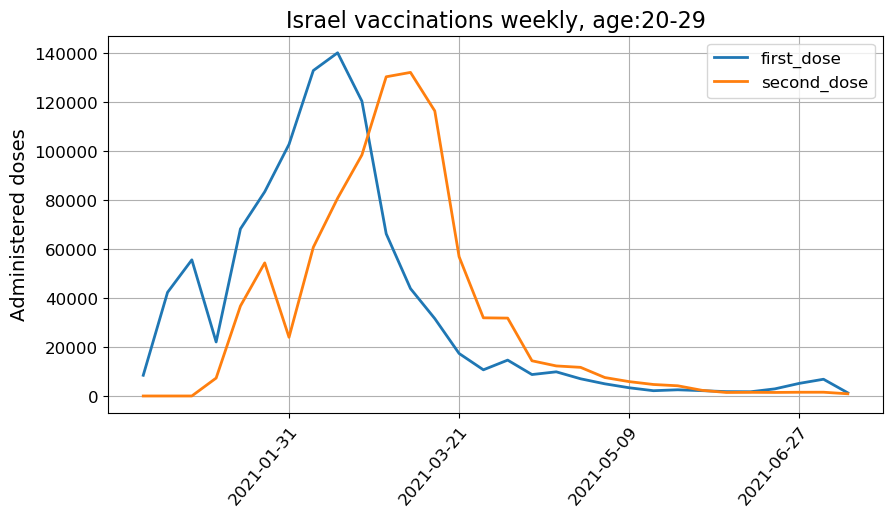

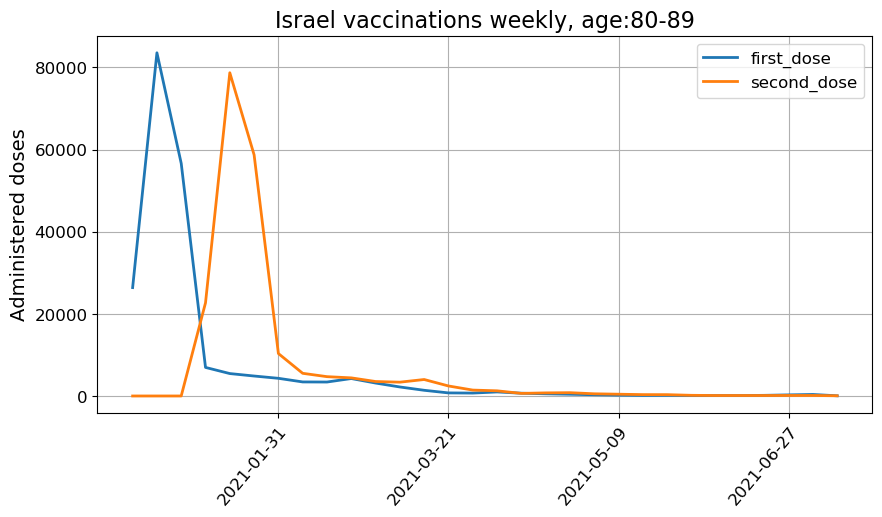

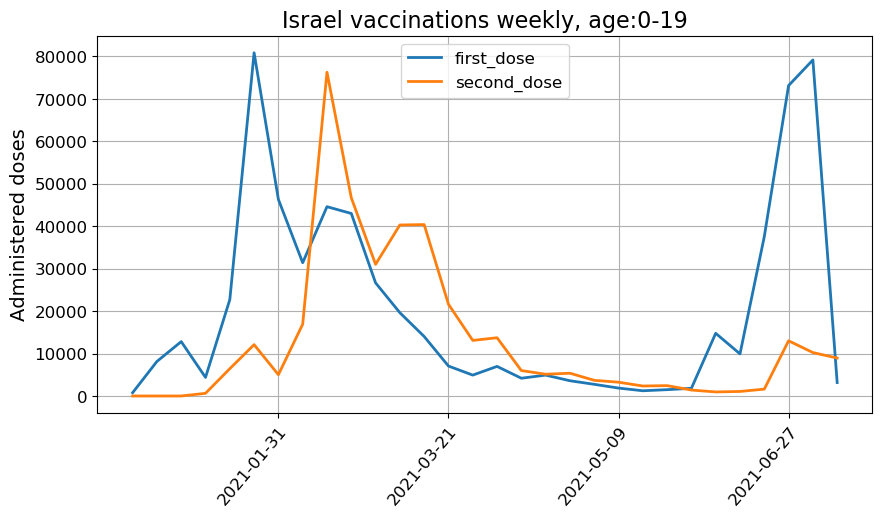

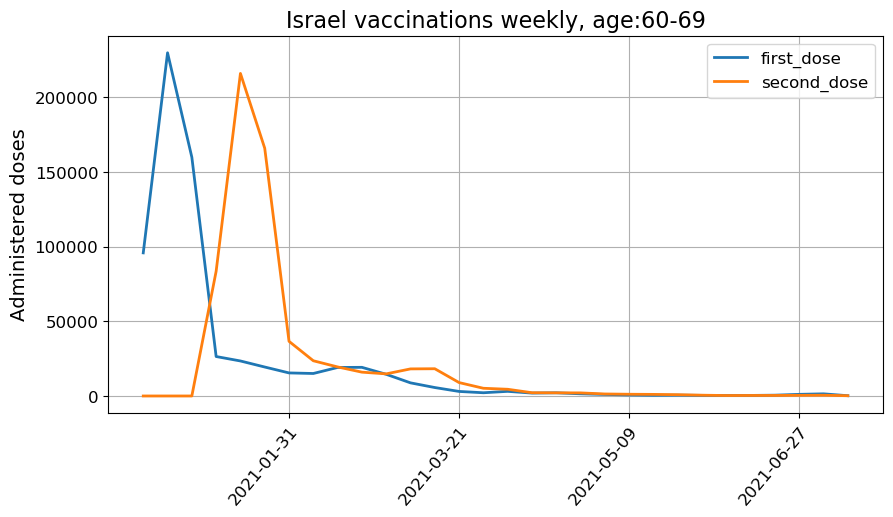

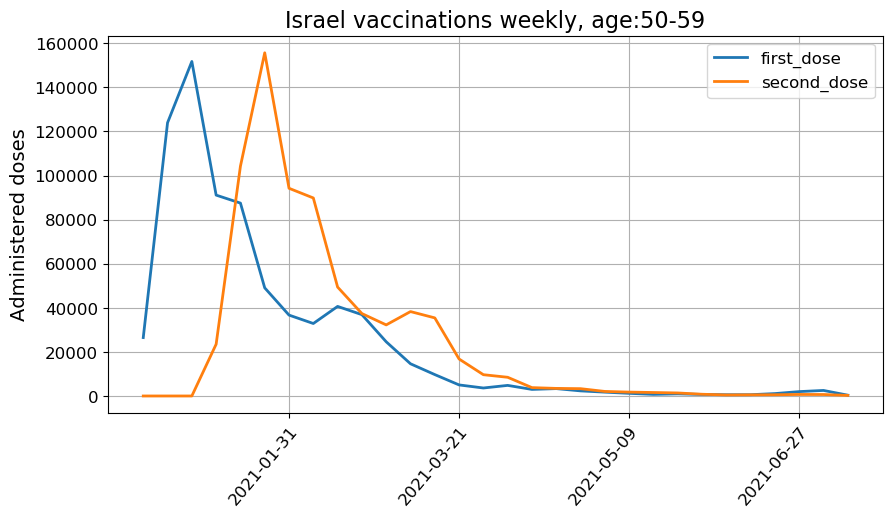

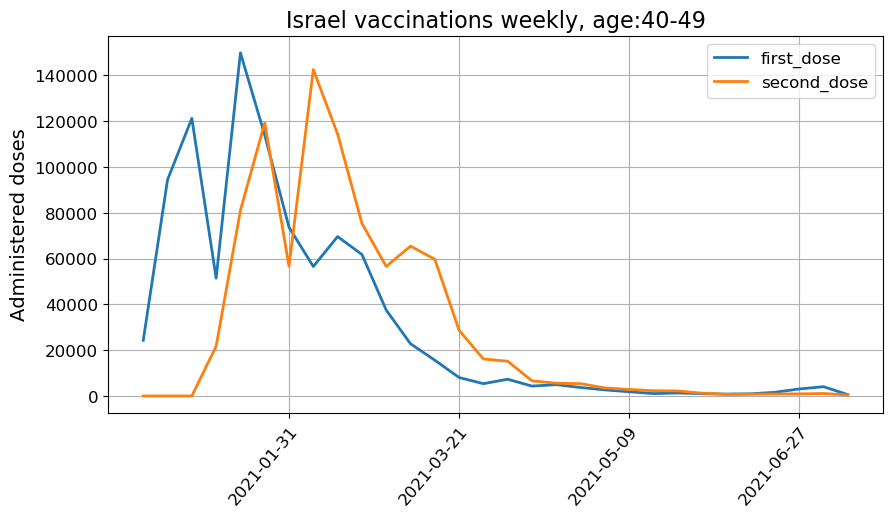

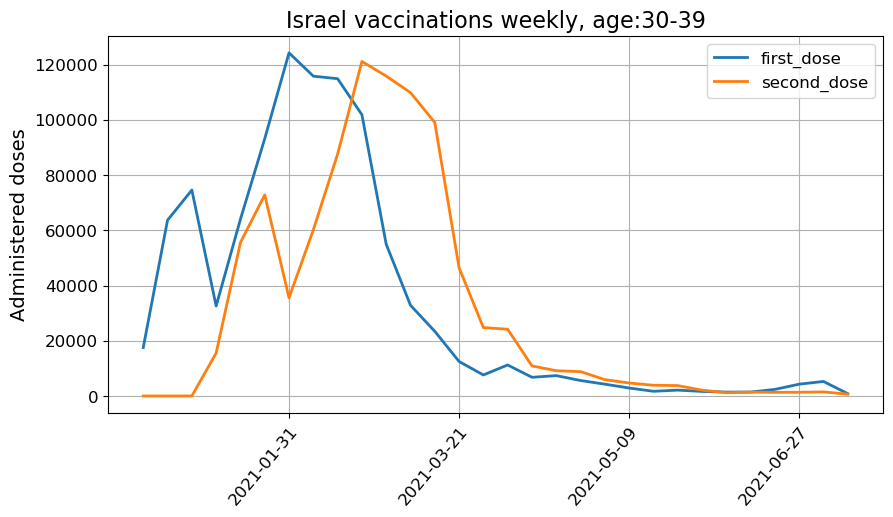

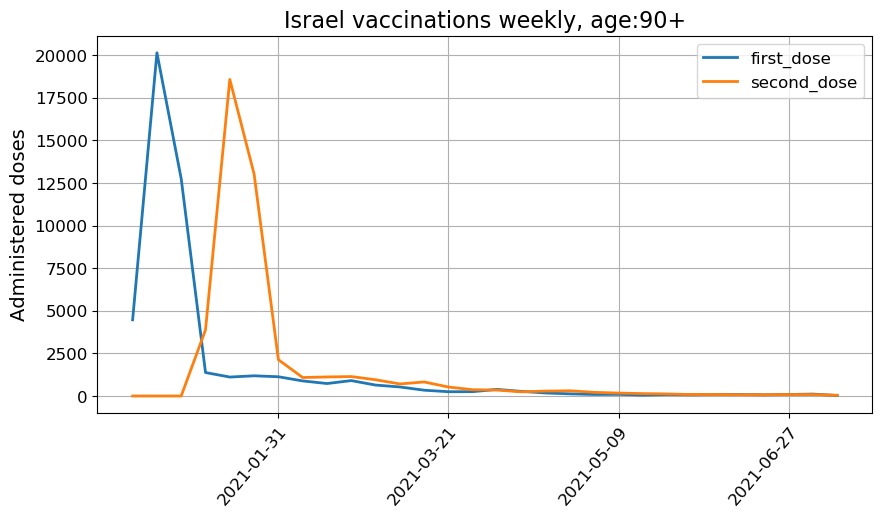

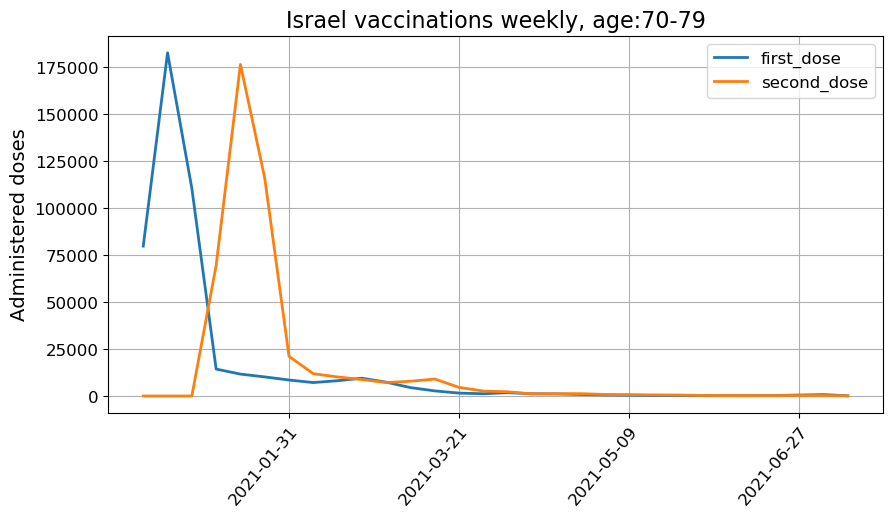

In [24]:
for age in age_groups:
    createXYPlot(df_vax_age_week[df_vax_age.age_group==age],
             y=["first_dose","second_dose"],
             today="",
             plots_folder=plot_folder,
             x="first_day",
             linewidth=2,
             start_date="2020-12-01",
             days_interval=7,
             bar=False,
             alpha=1,
             bar_width=0.3,
             bar_start=[-1,0,1],
             title=f"Israel vaccinations weekly, age:{age}",
             savename=f"Israel_vaccinations_weekly_{age}",
             ytitle="Administered doses"
            )

In [25]:
df_vax_age_week.head(10)

week age_group   over_60   first_day    last_day  \
0  2020-12-20 - 2020-12-26      0-19  under_60  2020-12-20  2020-12-26   
1  2020-12-20 - 2020-12-26     20-29  under_60  2020-12-20  2020-12-26   
2  2020-12-20 - 2020-12-26     30-39  under_60  2020-12-20  2020-12-26   
3  2020-12-20 - 2020-12-26     40-49  under_60  2020-12-20  2020-12-26   
4  2020-12-20 - 2020-12-26     50-59  under_60  2020-12-20  2020-12-26   
5  2020-12-20 - 2020-12-26     60-69   over_60  2020-12-20  2020-12-26   
6  2020-12-20 - 2020-12-26     70-79   over_60  2020-12-20  2020-12-26   
7  2020-12-20 - 2020-12-26     80-89   over_60  2020-12-20  2020-12-26   
8  2020-12-20 - 2020-12-26       90+   over_60  2020-12-20  2020-12-26   
9  2020-12-27 - 2021-01-02      0-19  under_60  2020-12-27  2021-01-02   

   first_dose  second_dose  
0       770.0          0.0  
1      8458.0          0.0  
2     17536.0          0.0  
3     24326.0          0.0  
4     26502.0          0.0  
5     95777.0          0.0  
6     79804.0          0.0  
7     26386.0          0.0  
8      4468.0          0.0  
9      8138.0          0.0

### Join with events data

In [26]:
df_event_doses = {}
index_columns=["week","first_day","last_day","age_group","over_60"]
df_events_doses = {}
for event in types:
    df_event_doses[event]=df_events_age[event].set_index(index_columns).join(df_vax_age_week.set_index(index_columns)).fillna(0)

In [27]:
df_event_doses["Hospitalization"]

event_1st_dose  \
week                    first_day  last_day   age_group over_60                    
2020-12-20 - 2020-12-26 2020-12-20 2020-12-26 0-19      under_60             0.0   
                                              20-29     under_60             0.0   
                                              30-39     under_60             0.0   
                                              40-49     under_60             0.0   
                                              50-59     under_60             0.0   
                                              60-69     over_60              4.0   
                                              70-79     over_60              4.0   
                                              80-89     over_60              0.0   
                                              90+       over_60              4.0   
2020-12-27 - 2021-01-02 2020-12-27 2021-01-02 0-19      under_60             0.0   
                                              20-29     under_60             0.0   
                                              30-39     under_60             4.0   
                                              40-49     under_60             0.0   
                                              50-59     under_60             4.0   
                                              60-69     over_60             17.0   
                                              70-79     over_60             22.0   
                                              80-89     over_60             29.0   
                                              90+       over_60              7.0   
2021-01-03 - 2021-01-09 2021-01-03 2021-01-09 0-19      under_60             0.0   
                                              20-29     under_60             9.0   
                                              30-39     under_60             4.0   
                                              40-49     under_60            18.0   
                                              50-59     under_60            32.0   
                                              60-69     over_60             74.0   
                                              70-79     over_60            113.0   
                                              80-89     over_60            128.0   
                                              90+       over_60             60.0   
2021-01-10 - 2021-01-16 2021-01-10 2021-01-16 0-19      under_60             4.0   
                                              20-29     under_60             5.0   
                                              30-39     under_60             9.0   
                                              40-49     under_60            19.0   
                                              50-59     under_60            52.0   
                                              60-69     over_60            146.0   
                                              70-79     over_60            195.0   
                                              80-89     over_60            177.0   
                                              90+       over_60             87.0   
2021-01-17 - 2021-01-23 2021-01-17 2021-01-23 0-19      under_60             0.0   
                                              20-29     under_60             4.0   
                                              30-39     under_60             5.0   
                                              40-49     under_60            19.0   
                                              50-59     under_60            50.0   
                                              60-69     over_60            121.0   
                                              70-79     over_60            133.0   
                                              80-89     over_60            167.0   
                                              90+       over_60             85.0   
2021-01-24 - 2021-01-30 2021-01-24 2021-01-30 0-19      under_60             4.0   
                                  

### Population
https://www.cbs.gov.il/he/publications/LochutTlushim/2020/%D7%90%D7%95%D7%9B%D7%9C%D7%95%D7%A1%D7%99%D7%99%D7%942019-2000.xlsx

In [28]:
df_isr_pop=pd.read_csv("./data/israeli_pop.csv")

In [29]:
df_isr_pop = df_isr_pop[df_isr_pop.age != "total"]
df_isr_pop["age"] = df_isr_pop["age"].apply(lambda x: 90 if x == "90+" else int(x)).astype('int')

In [30]:
pop_dict = {}
for age_bucket in sorted(age_groups):
    if age_bucket != "90+":
        age_lo = int(age_bucket.split("-")[0])
        age_hi = int(age_bucket.split("-")[1])
    else:
        age_lo = 90
        age_hi = 99999
    print(f"Age lo: {age_lo}, Age hi: {age_hi}")
    df_pop = df_isr_pop[(df_isr_pop.age >= age_lo) &  (df_isr_pop.age <= age_hi)]
    pop_dict[age_bucket] = np.sum(df_pop["pop"])
    
df_pop_strata=pd.DataFrame.from_dict(pop_dict,orient="index",columns=["population"]).sort_index()

Age lo: 0, Age hi: 19
Age lo: 20, Age hi: 29
Age lo: 30, Age hi: 39
Age lo: 40, Age hi: 49
Age lo: 50, Age hi: 59
Age lo: 60, Age hi: 69
Age lo: 70, Age hi: 79
Age lo: 80, Age hi: 89
Age lo: 90, Age hi: 99999


In [31]:
df_pop_strata

population
0-19      3292329
20-29     1277634
30-39     1186386
40-49     1080768
50-59      832687
60-69      735380
70-79      462148
80-89      222547
90+         50589

In [32]:
df_event_doses_pop = {}
for event in types:
    df_event_doses_pop[event] = df_event_doses[event].reset_index().set_index("age_group").join(df_pop_strata)
    df_event_doses_pop[event] = df_event_doses_pop[event].reset_index().rename(columns={"index":"age_group"})
    df_event_doses_pop[event] = df_event_doses_pop[event].sort_values(by=["age_group","first_day"])
    df_event_doses_pop[event]["pop_1st_dose"] = df_event_doses_pop[event][["age_group","first_dose"]].groupby("age_group").cumsum()
    df_event_doses_pop[event]["pop_2nd_dose"] = df_event_doses_pop[event][["age_group","second_dose"]].groupby("age_group").cumsum()
    df_event_doses_pop[event]["pop_no_vax"] = df_event_doses_pop[event]["population"] - df_event_doses_pop[event]["pop_1st_dose"]
    df_event_doses_pop[event]["share_1st_dose"] = df_event_doses_pop[event]["pop_1st_dose"]/df_event_doses_pop[event]["population"]
    df_event_doses_pop[event]["share_2nd_dose"] = df_event_doses_pop[event]["pop_2nd_dose"]/df_event_doses_pop[event]["population"]
    df_event_doses_pop[event]["share_no_vax"] = df_event_doses_pop[event]["pop_no_vax"]/df_event_doses_pop[event]["population"]
    
    # For 70-79 100% results vaccinated 
    df_event_doses_pop[event]["share_1st_dose"] = df_event_doses_pop[event]["share_1st_dose"].apply(lambda x: 1 if x > 1 else x)
                                                                  

In [33]:
for age in sorted(age_groups):
    df_vax_share = df_event_doses_pop["Hospitalization"][df_event_doses_pop["Hospitalization"]["age_group"]==age]
    display(df_vax_share[["week","age_group","pop_1st_dose","population","share_1st_dose","over_60"]].tail(2))

week age_group  pop_1st_dose  population  \
27  2021-06-27 - 2021-07-03      0-19      531412.0     3292329   
28  2021-07-04 - 2021-07-10      0-19      610592.0     3292329   

    share_1st_dose   over_60  
27        0.161409  under_60  
28        0.185459  under_60

week age_group  pop_1st_dose  population  \
56  2021-06-27 - 2021-07-03     20-29     1013358.0     1277634   
57  2021-07-04 - 2021-07-10     20-29     1020196.0     1277634   

    share_1st_dose   over_60  
56        0.793152  under_60  
57        0.798504  under_60

week age_group  pop_1st_dose  population  \
85  2021-06-27 - 2021-07-03     30-39      986653.0     1186386   
86  2021-07-04 - 2021-07-10     30-39      991908.0     1186386   

    share_1st_dose   over_60  
85        0.831646  under_60  
86        0.836075  under_60

week age_group  pop_1st_dose  population  \
114  2021-06-27 - 2021-07-03     40-49      941127.0     1080768   
115  2021-07-04 - 2021-07-10     40-49      945189.0     1080768   

     share_1st_dose   over_60  
114        0.870795  under_60  
115        0.874553  under_60

week age_group  pop_1st_dose  population  \
143  2021-06-27 - 2021-07-03     50-59      757591.0      832687   
144  2021-07-04 - 2021-07-10     50-59      760103.0      832687   

     share_1st_dose   over_60  
143        0.909815  under_60  
144        0.912832  under_60

week age_group  pop_1st_dose  population  \
172  2021-06-27 - 2021-07-03     60-69      671380.0      735380   
173  2021-07-04 - 2021-07-10     60-69      672813.0      735380   

     share_1st_dose  over_60  
172        0.912970  over_60  
173        0.914919  over_60

week age_group  pop_1st_dose  population  \
201  2021-06-27 - 2021-07-03     70-79      467405.0      462148   
202  2021-07-04 - 2021-07-10     70-79      468143.0      462148   

     share_1st_dose  over_60  
201             1.0  over_60  
202             1.0  over_60

week age_group  pop_1st_dose  population  \
230  2021-06-27 - 2021-07-03     80-89      211514.0      222547   
231  2021-07-04 - 2021-07-10     80-89      211882.0      222547   

     share_1st_dose  over_60  
230        0.950424  over_60  
231        0.952078  over_60

week age_group  pop_1st_dose  population  \
259  2021-06-27 - 2021-07-03       90+       48338.0       50589   
260  2021-07-04 - 2021-07-10       90+       48449.0       50589   

     share_1st_dose  over_60  
259        0.955504  over_60  
260        0.957698  over_60

In [34]:
df_all_ages_vax_latest = df_event_doses_pop["Hospitalization"][df_event_doses_pop["Hospitalization"]["last_day"]==last_day]

tot_1st_dose = np.sum(df_all_ages_vax_latest["pop_1st_dose"])
tot_2nd_dose = np.sum(df_all_ages_vax_latest["pop_2nd_dose"])
tot_population = np.sum(df_all_ages_vax_latest["population"])

print(f"Vaccinated 1st dose: {tot_1st_dose/tot_population}")
print(f"Vaccinated 2nd dose: {tot_2nd_dose/tot_population}")

Vaccinated 1st dose: 0.6268032446478671
Vaccinated 2nd dose: 0.56795636722321


/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


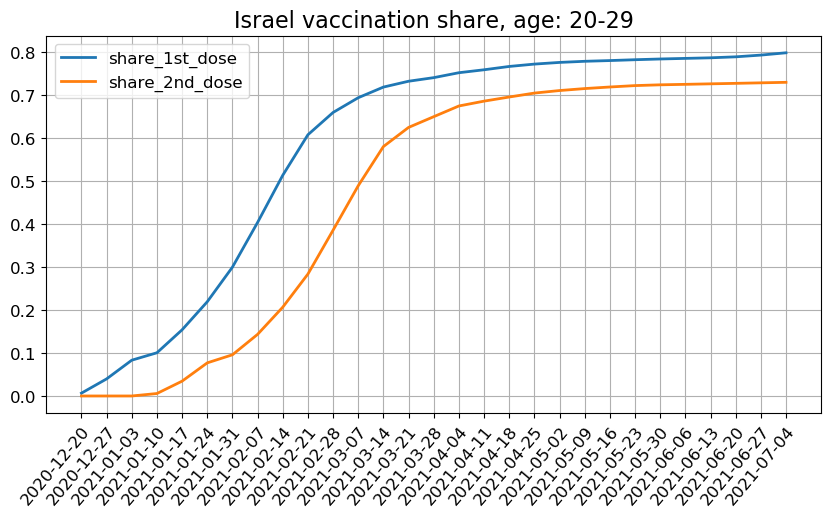

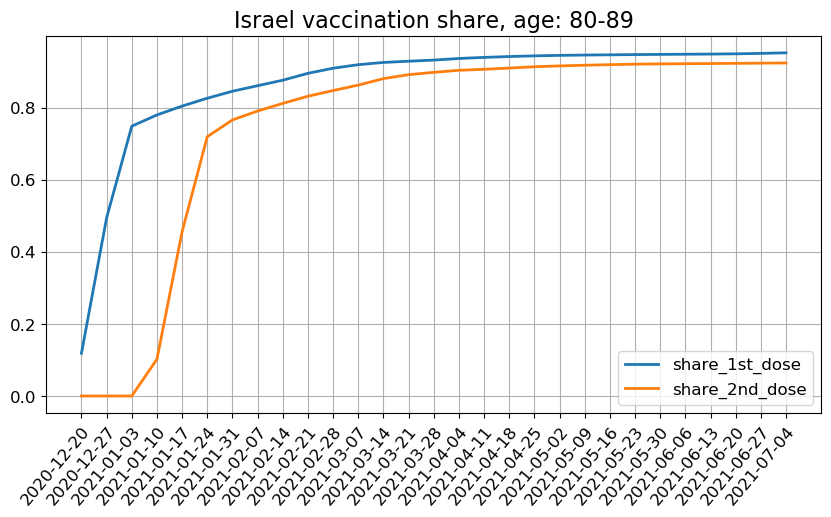

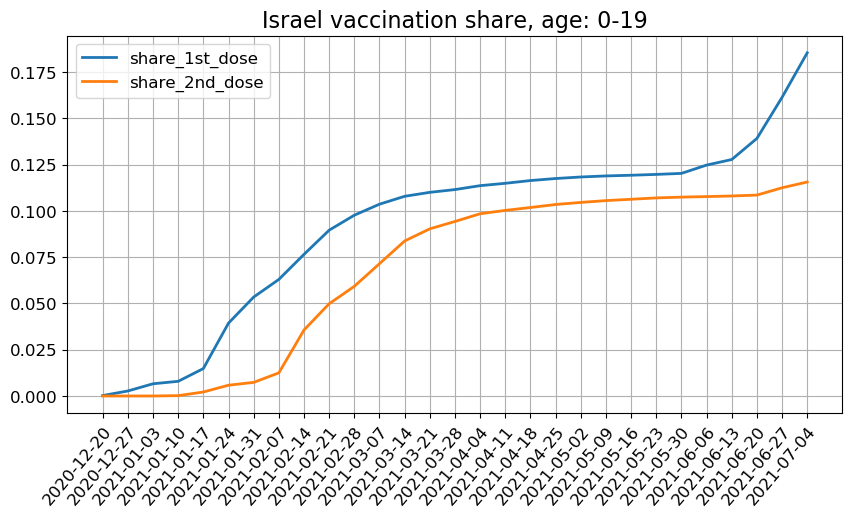

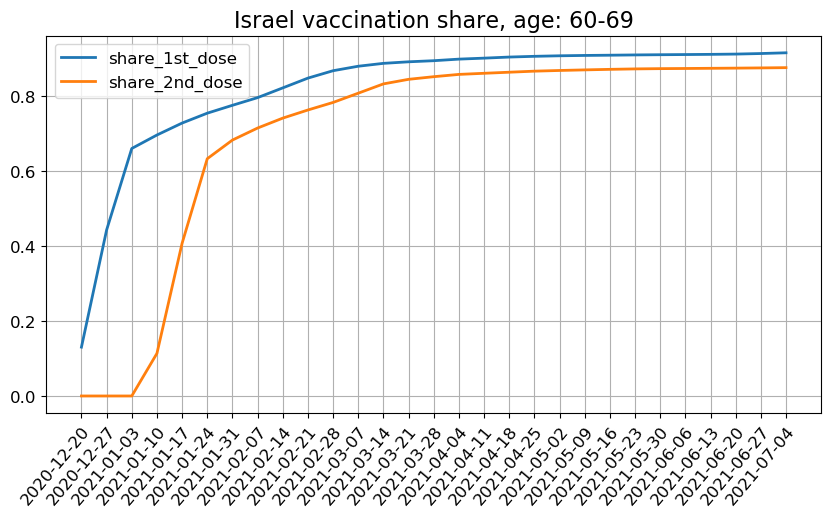

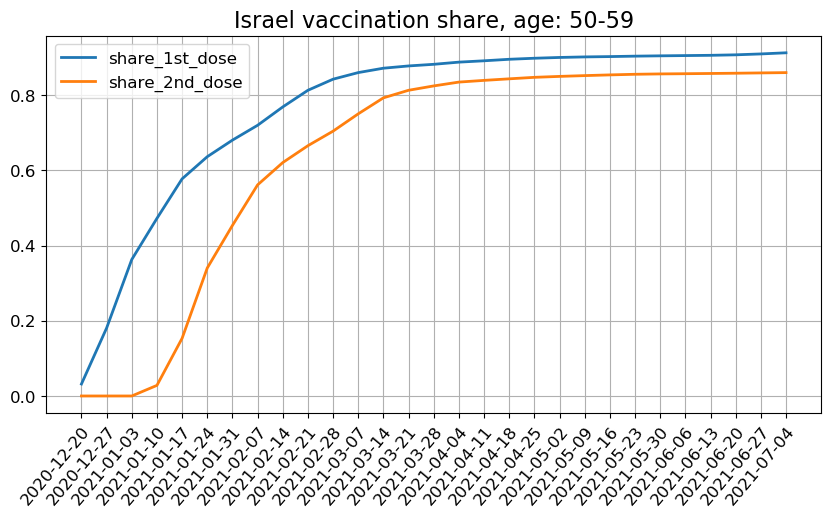

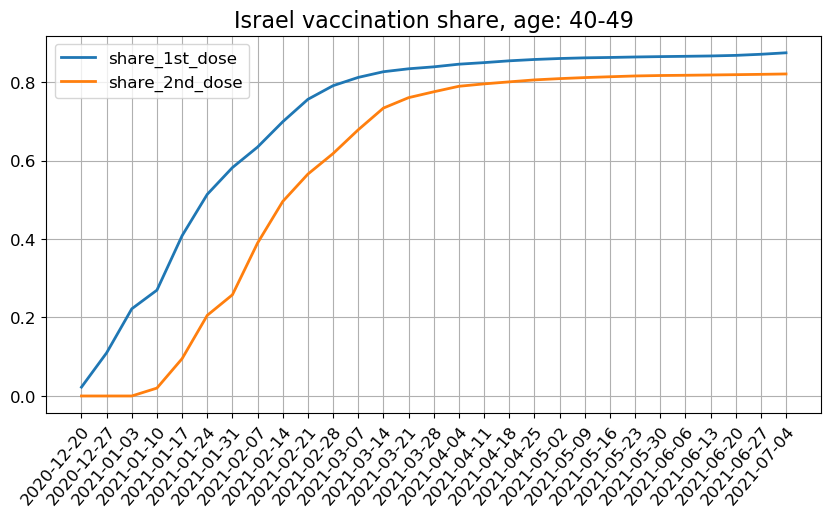

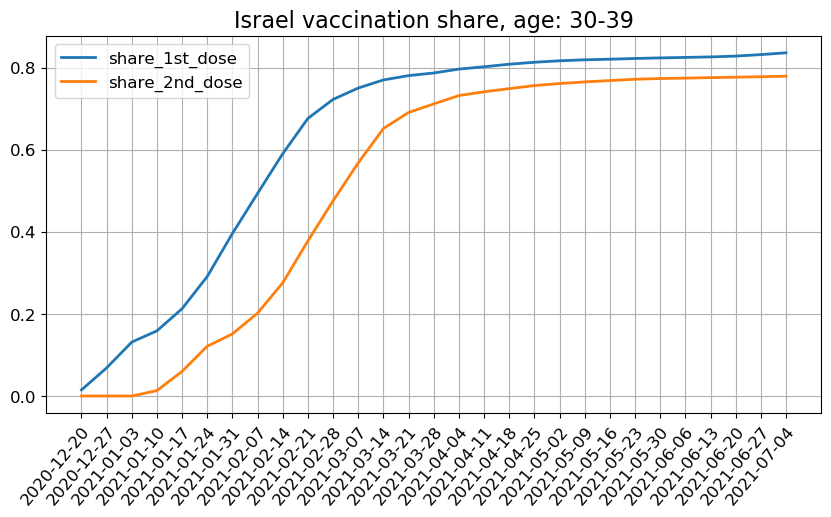

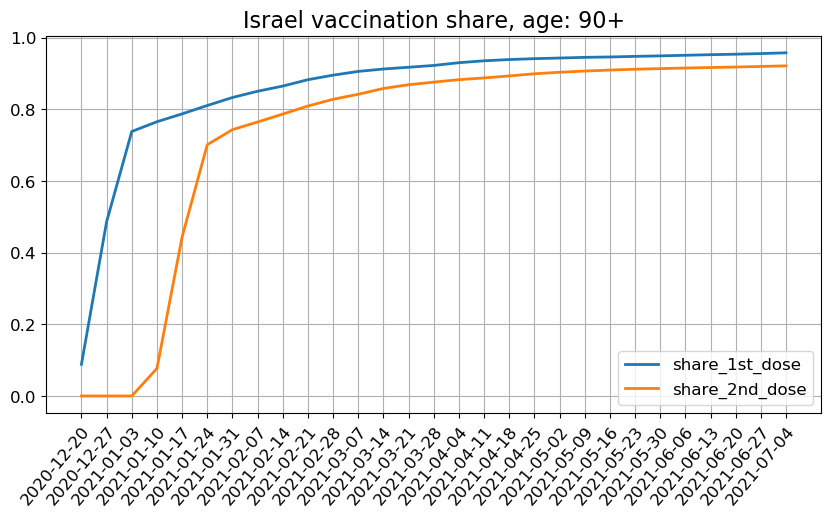

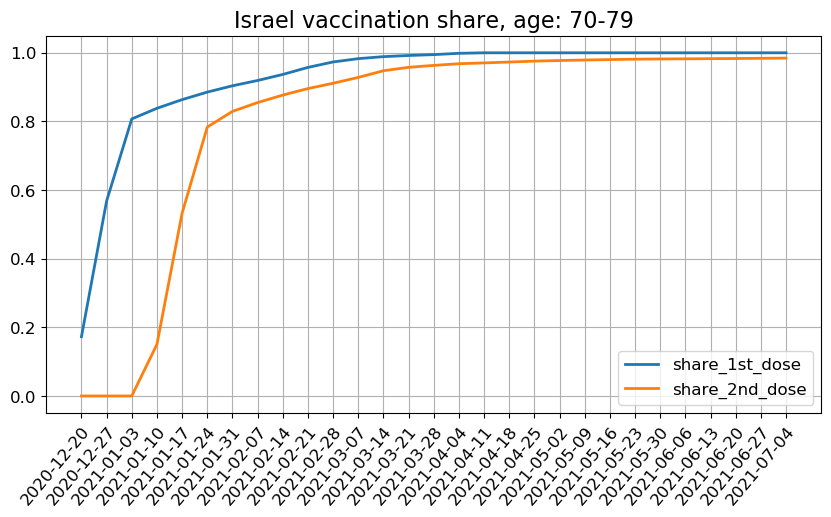

In [35]:
for age in age_groups:
    createXYPlot(df_event_doses_pop["Hospitalization"][df_event_doses_pop["Hospitalization"]["age_group"]==age],
                     y=["share_1st_dose","share_2nd_dose"],
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2020-12-01",
                     days_interval=1,
                     bar=False,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel vaccination share, age: {age}",
                     savename=f"Israel_vaccination_share_{age}"
            )
    

### Aggregate over under/over 60

In [36]:
df_event_doses_pop_60 = {}
for event in types:
    df_event_doses_pop_60[event] = df_event_doses_pop[event].groupby(["week","first_day","over_60"])\
    .agg(pop_1st_dose=("pop_1st_dose","sum"),
         pop_2nd_dose=("pop_2nd_dose","sum"),
         population=("population","sum")
    ).reset_index()
    df_event_doses_pop_60[event]["pop_no_vax"] = df_event_doses_pop_60[event]["population"] - df_event_doses_pop_60[event]["pop_1st_dose"]

    df_event_doses_pop_60[event]["share_1st_dose"] = df_event_doses_pop_60[event]["pop_1st_dose"]/df_event_doses_pop_60[event]["population"]
    df_event_doses_pop_60[event]["share_2nd_dose"] = df_event_doses_pop_60[event]["pop_2nd_dose"]/df_event_doses_pop_60[event]["population"]
    df_event_doses_pop_60[event]["share_no_vax"] = df_event_doses_pop_60[event]["pop_no_vax"]/df_event_doses_pop_60[event]["population"]

In [37]:
df_event_doses_pop_60["Hospitalization"]

week   first_day   over_60  pop_1st_dose  pop_2nd_dose  \
0   2020-12-20 - 2020-12-26  2020-12-20   over_60      206435.0           0.0   
1   2020-12-20 - 2020-12-26  2020-12-20  under_60       77592.0           0.0   
2   2020-12-27 - 2021-01-02  2020-12-27   over_60      722535.0           0.0   
3   2020-12-27 - 2021-01-02  2020-12-27  under_60      410149.0           0.0   
4   2021-01-03 - 2021-01-09  2021-01-03   over_60     1062220.0           0.0   
5   2021-01-03 - 2021-01-09  2021-01-03  under_60      826187.0           0.0   
6   2021-01-10 - 2021-01-16  2021-01-10   over_60     1111282.0      179588.0   
7   2021-01-10 - 2021-01-16  2021-01-10  under_60     1027786.0       68682.0   
8   2021-01-17 - 2021-01-23  2021-01-17   over_60     1152926.0      669252.0   
9   2021-01-17 - 2021-01-23  2021-01-17  under_60     1420173.0      352774.0   
10  2021-01-24 - 2021-01-30  2021-01-24   over_60     1188502.0     1022826.0   
11  2021-01-24 - 2021-01-30  2021-01-24  under_60     1840652.0      767048.0   
12  2021-01-31 - 2021-02-06  2021-01-31   over_60     1217858.0     1092957.0   
13  2021-01-31 - 2021-02-06  2021-01-31  under_60     2224383.0      982403.0   
14  2021-02-07 - 2021-02-13  2021-02-07   over_60     1244356.0     1134992.0   
15  2021-02-07 - 2021-02-13  2021-02-07  under_60     2593974.0     1352634.0   
16  2021-02-14 - 2021-02-20  2021-02-14   over_60     1275700.0     1170378.0   
17  2021-02-14 - 2021-02-20  2021-02-14  under_60     3003914.0     1761112.0   
18  2021-02-21 - 2021-02-27  2021-02-21   over_60     1309484.0     1200630.0   
19  2021-02-21 - 2021-02-27  2021-02-21  under_60     3367904.0     2140219.0   
20  2021-02-28 - 2021-03-06  2021-02-28   over_60     1335132.0     1227047.0   
21  2021-02-28 - 2021-03-06  2021-02-28  under_60     3577893.0     2506305.0   
22  2021-03-07 - 2021-03-13  2021-03-07   over_60     1351098.0     1257085.0   
23  2021-03-07 - 2021-03-13  2021-03-07  under_60     3711650.0     2892371.0   
24  2021-03-14 - 2021-03-20  2021-03-14   over_60     1361186.0     1289173.0   
25  2021-03-14 - 2021-03-20  2021-03-14  under_60     3806030.0     3243408.0   
26  2021-03-21 - 2021-03-27  2021-03-21   over_60     1366745.0     1305681.0   
27  2021-03-21 - 2021-03-27  2021-03-21  under_60     3856023.0     3413804.0   
28  2021-03-28 - 2021-04-03  2021-03-28   over_60     1371044.0     1315274.0   
29  2021-03-28 - 2021-04-03  2021-03-28  under_60     3888232.0     3509425.0   
30  2021-04-04 - 2021-04-10  2021-04-04   over_60     1377280.0     1323599.0   
31  2021-04-04 - 2021-04-10  2021-04-04  under_60     3933201.0     3602784.0   
32  2021-04-11 - 2021-04-17  2021-04-11   over_60     1381318.0     1327787.0   
33  2021-04-11 - 2021-04-17  2021-04-11  under_60     3960200.0     3644428.0   
34  2021-04-18 - 2021-04-24  2021-04-18   over_60     1385260.0     1332072.0   
35  2021-04-18 - 2021-04-24  2021-04-18  under_60     3990646.0     3679988.0   
36  2021-04-25 - 2021-05-01  2021-04-25   over_60     1388069.0     1336478.0   
37  2021-04-25 - 2021-05-01  2021-04-25  under_60     4012877.0     3714560.0   
38  2021-05-02 - 2021-05-08  2021-05-02   over_60     1390048.0     1339371.0   
39  2021-05-02 - 2021-05-08  2021-05-02  under_60     4029268.0     3737290.0   
40  2021-05-09 - 2021-05-15  2021-05-09   over_60     1391442.0     1341836.0   
41  2021-05-09 - 2021-05-15  2021-05-09  under_60     4040412.0     3755722.0   
42  2021-05-16 - 2021-05-22  2021-05-16   over_60     1392342.0     1343942.0   
43  2021-05-16 - 2021-05-22  2021-05-16  under_60     4047272.0     3770523.0   
44  2021-05-23 - 2021-05-29  2021-05-23   over_60     1393402.0     1345764.0   
45  2021-05-23 - 2021-05-29  2021-05-23  under_60     4055680.0     3784446.0   
46  2021-05-30 - 2021-06-05  2021-05-30   over_60     1394204.0     1346827.0   
47  2021-05-30 - 2021-06-05  2021-05-30  under_60     4063041.0     3792255.0   
48  2021-06-06 - 2021-06-12  2021-06-06   over_60     

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


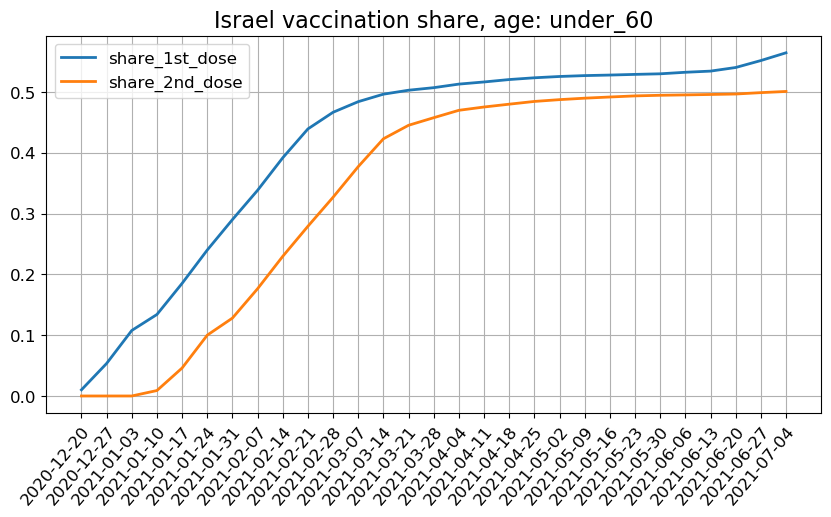

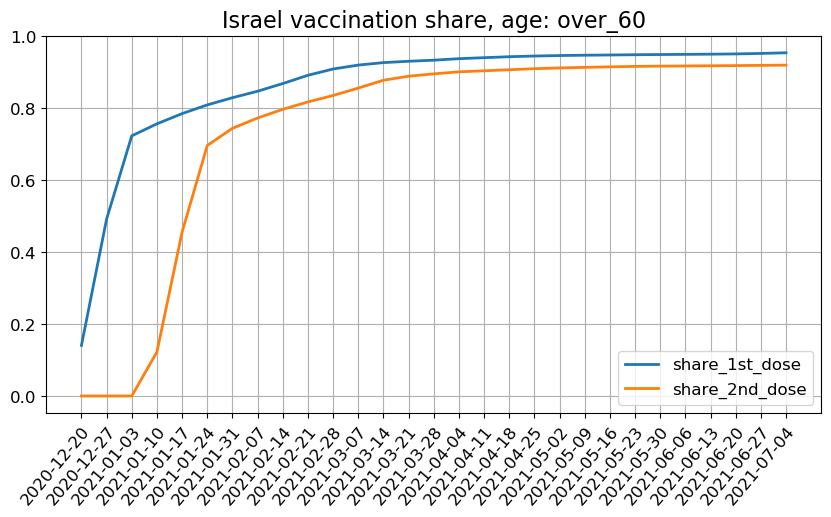

In [38]:
for age in ["under_60","over_60"]:
    createXYPlot(df_event_doses_pop_60["Hospitalization"][df_event_doses_pop_60["Hospitalization"]["over_60"]==age],
                     y=["share_1st_dose","share_2nd_dose"],
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2020-12-01",
                     days_interval=1,
                     bar=False,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel vaccination share, age: {age}",
                     savename=f"Israel_vaccination_share_{age}"
            )
    

Event: Hospitalization
Age group: 0-19


week  event_2nd_dose  event_no_vax  \
25  2021-06-13 - 2021-06-19             0.0           0.0   
26  2021-06-20 - 2021-06-26             0.0           4.0   
27  2021-06-27 - 2021-07-03             0.0           6.0   
28  2021-07-04 - 2021-07-10             4.0           4.0   

    ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
25                   0.0                 0.000               0.000   
26                   0.0                 0.000               0.141   
27                   0.0                 0.000               0.217   
28                   0.0                 1.051               0.149   

    efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
25                NaN                NaN                    NaN  
26                1.0              1.000               1.353835  
27                1.0              1.000               1.107085  
28                1.0             -6.054             168.961240

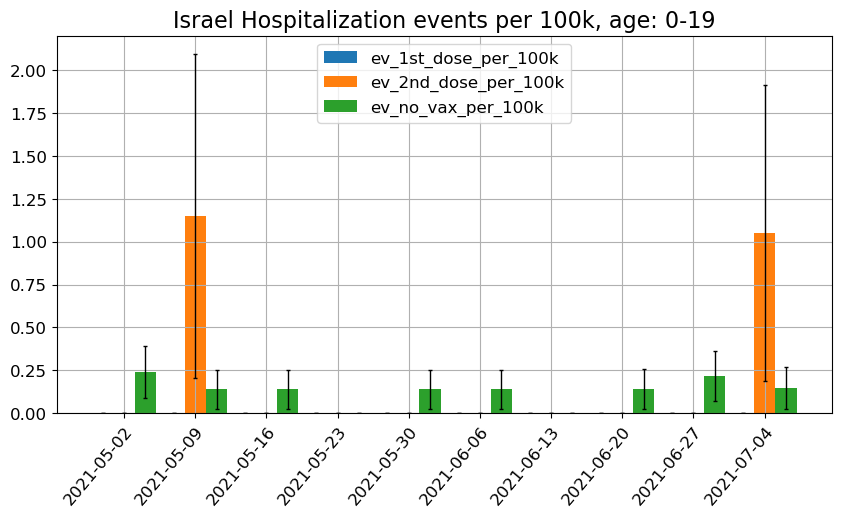

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


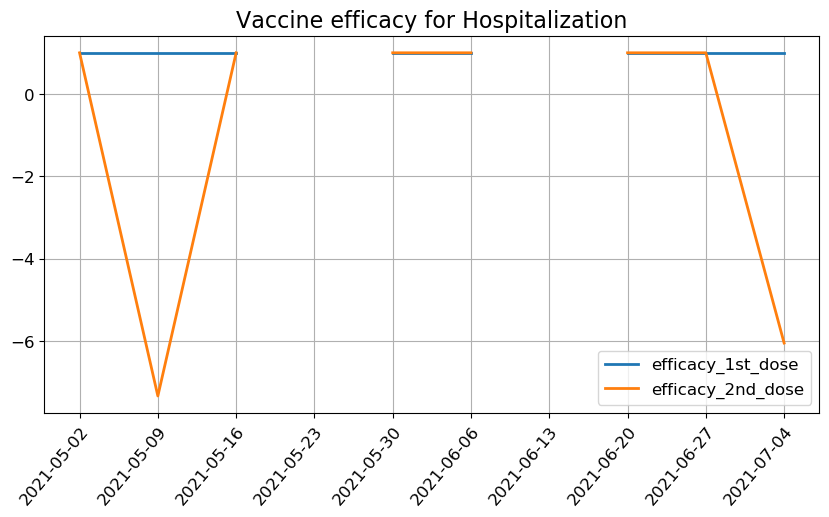

Event: Hospitalization
Age group: 20-29


week  event_2nd_dose  event_no_vax  \
54  2021-06-13 - 2021-06-19             4.0           0.0   
55  2021-06-20 - 2021-06-26             0.0           4.0   
56  2021-06-27 - 2021-07-03             4.0           6.0   
57  2021-07-04 - 2021-07-10             4.0           4.0   

    ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
54                 0.000                 0.431               0.000   
55                 0.000                 0.000               1.485   
56                 0.000                 0.430               2.270   
57                 0.392                 0.429               1.554   

    efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
54                NaN              0.000                    NaN  
55              1.000              1.000               1.352190  
56              1.000              0.811               1.218945  
57              0.748              0.724               1.225525

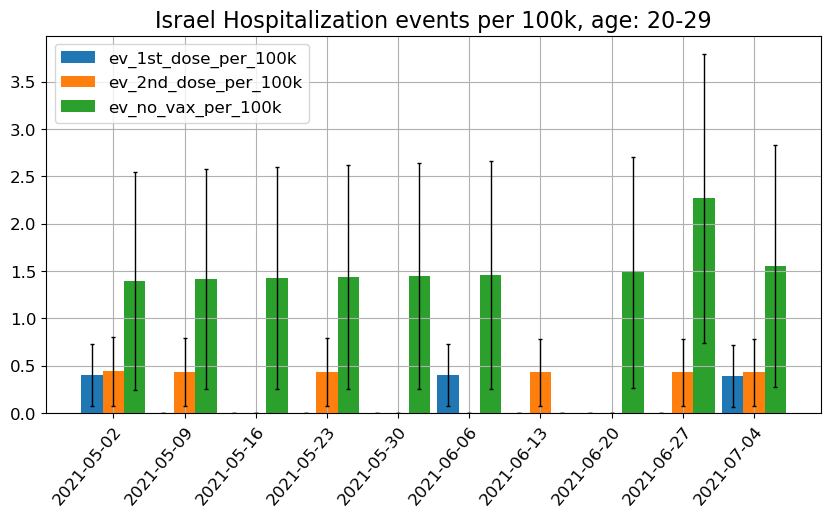

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


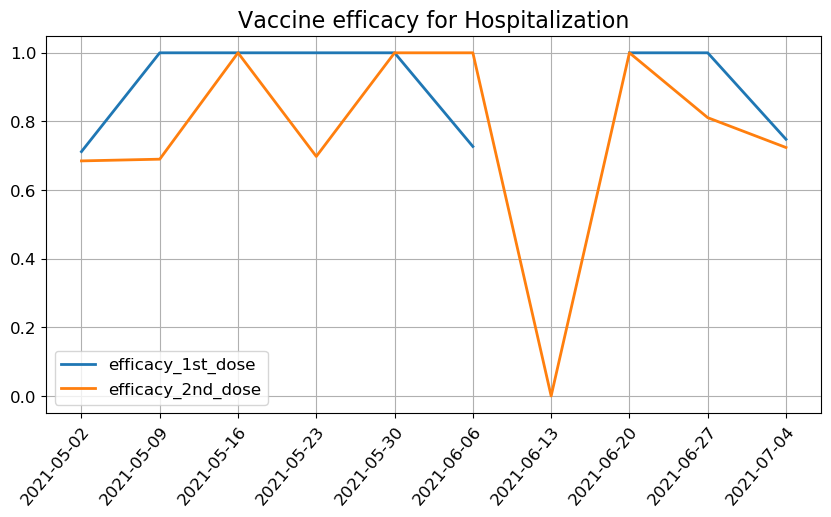

Event: Hospitalization
Age group: 30-39


week  event_2nd_dose  event_no_vax  \
83  2021-06-13 - 2021-06-19             0.0           4.0   
84  2021-06-20 - 2021-06-26             0.0           4.0   
85  2021-06-27 - 2021-07-03             4.0           4.0   
86  2021-07-04 - 2021-07-10             4.0           4.0   

    ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
83                 0.000                 0.000               1.938   
84                 0.000                 0.000               1.961   
85                 0.405                 0.433               2.003   
86                 0.403                 0.433               2.057   

    efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
83              1.000              1.000                1.35219  
84              1.000              1.000                1.35219  
85              0.798              0.784                1.33574  
86              0.804              0.789                1.34232

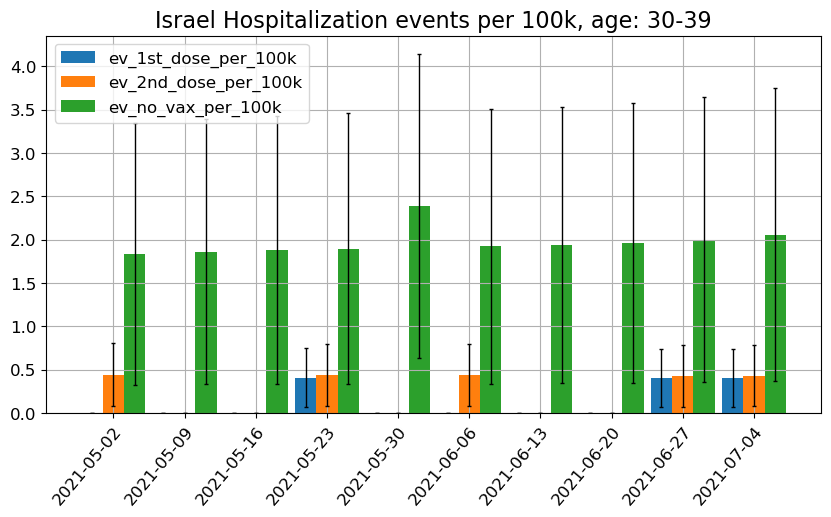

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


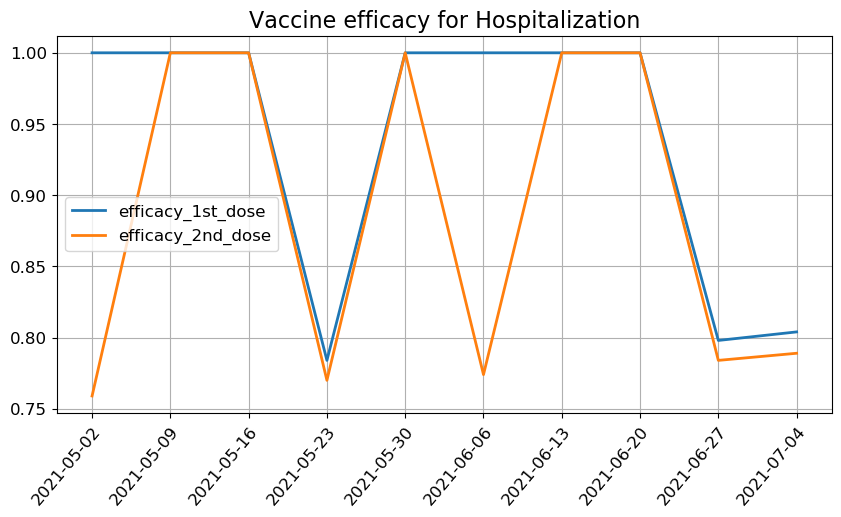

Event: Hospitalization
Age group: 40-49


week  event_2nd_dose  event_no_vax  \
112  2021-06-13 - 2021-06-19             4.0           4.0   
113  2021-06-20 - 2021-06-26             4.0           4.0   
114  2021-06-27 - 2021-07-03             4.0           4.0   
115  2021-07-04 - 2021-07-10             4.0           4.0   

     ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
112                 0.427                 0.452               2.772   
113                 0.426                 0.452               2.803   
114                 0.000                 0.452               2.864   
115                 0.000                 0.451               2.950   

     efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
112              0.846              0.837               1.468985  
113              0.848              0.839               1.472275  
114              1.000              0.842               1.475565  
115              1.000              0.847               1.483790

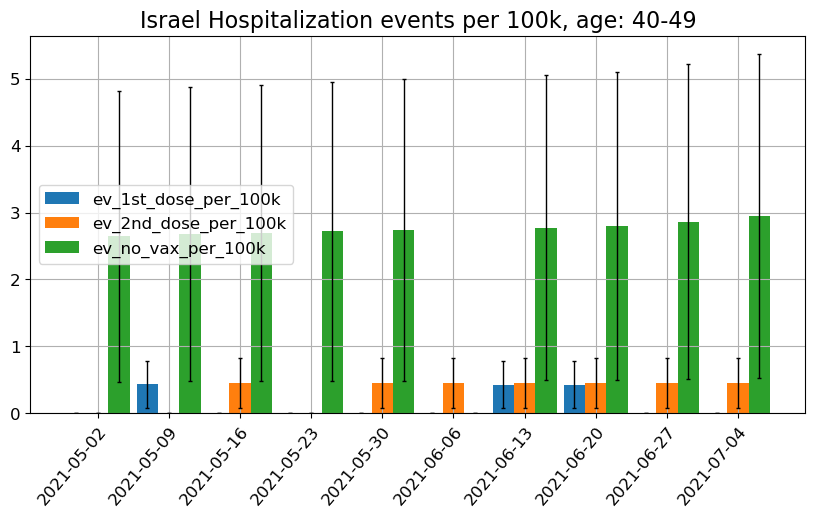

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


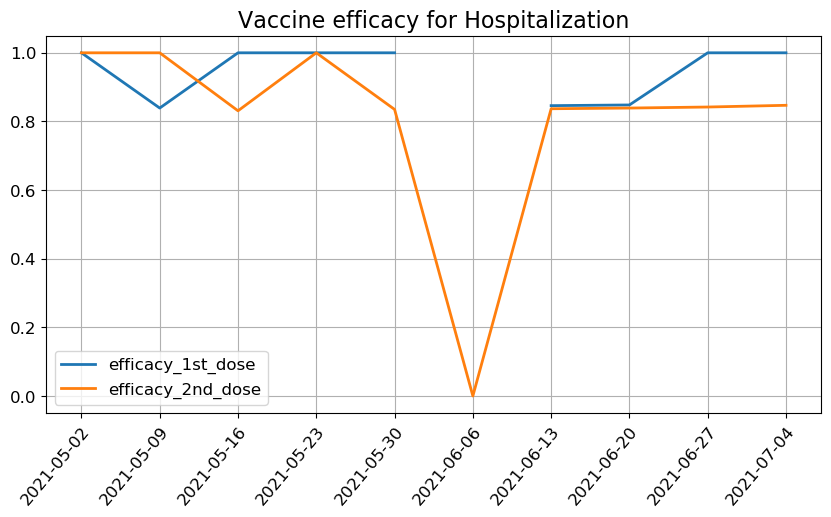

Event: Hospitalization
Age group: 50-59


week  event_2nd_dose  event_no_vax  \
141  2021-06-13 - 2021-06-19             4.0           0.0   
142  2021-06-20 - 2021-06-26             0.0           0.0   
143  2021-06-27 - 2021-07-03             4.0           4.0   
144  2021-07-04 - 2021-07-10             4.0           4.0   

     ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
141                 0.000                 0.560               0.000   
142                 0.529                 0.000               0.000   
143                 0.528                 0.559               5.327   
144                 0.000                 0.558               5.511   

     efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
141                NaN              0.000                    NaN  
142              0.000                NaN                    NaN  
143              0.901              0.895               1.954260  
144              1.000              0.899               1.959195

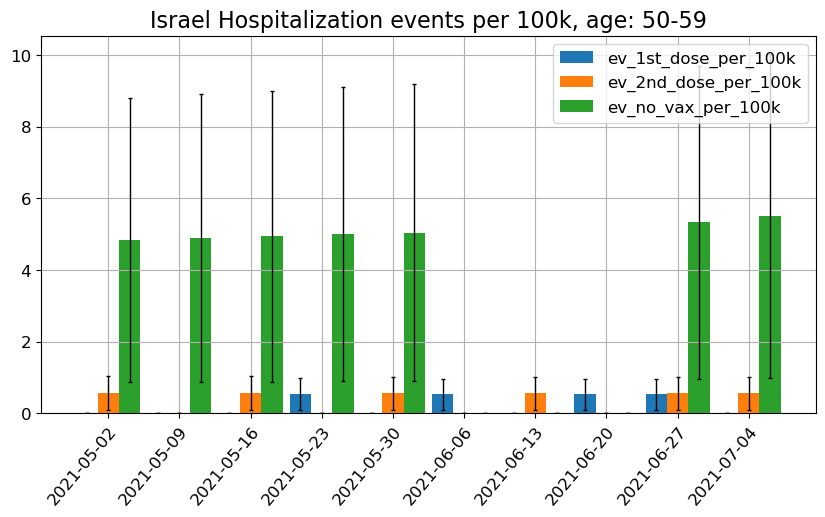

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


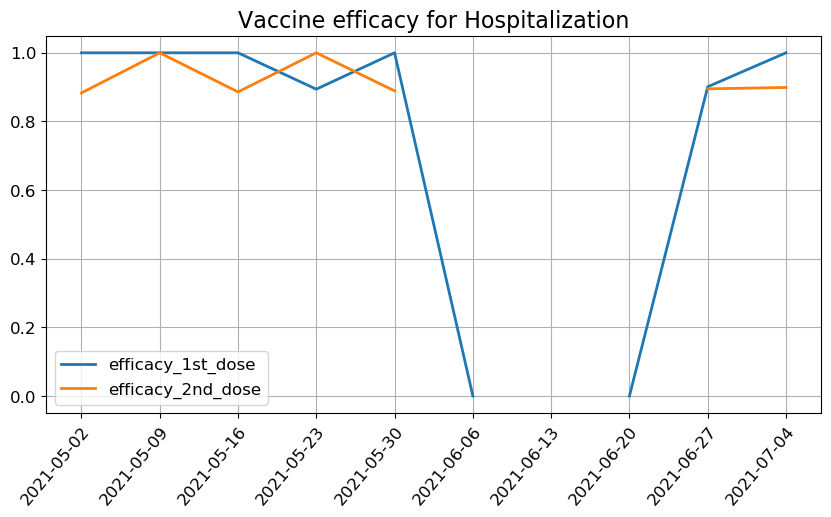

Event: Hospitalization
Age group: 60-69


week  event_2nd_dose  event_no_vax  \
170  2021-06-13 - 2021-06-19             4.0           4.0   
171  2021-06-20 - 2021-06-26             4.0           4.0   
172  2021-06-27 - 2021-07-03             4.0           4.0   
173  2021-07-04 - 2021-07-10            14.0           4.0   

     ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
170                 0.000                 0.623               6.095   
171                 0.597                 0.622               6.145   
172                 0.000                 0.622               6.250   
173                 0.000                 2.175               6.393   

     efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
170              1.000              0.898               2.345770  
171              0.903              0.899               2.342480  
172              1.000              0.900               2.344125  
173              1.000              0.660               1.256780

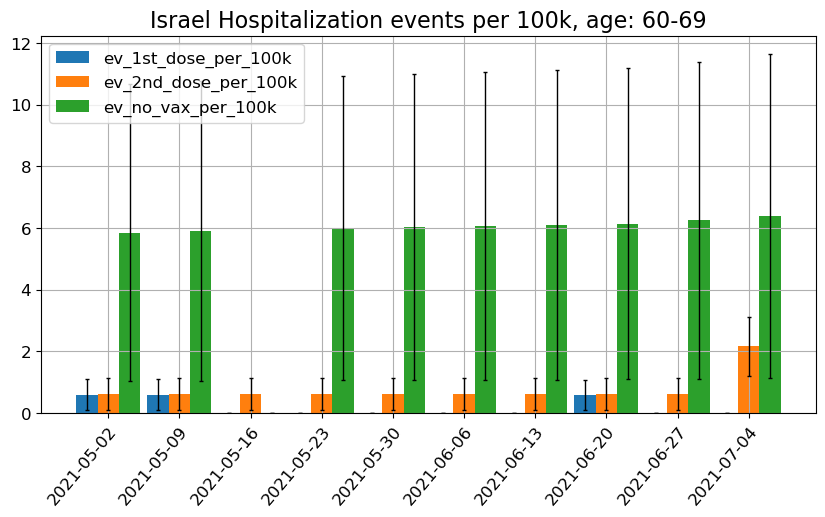

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


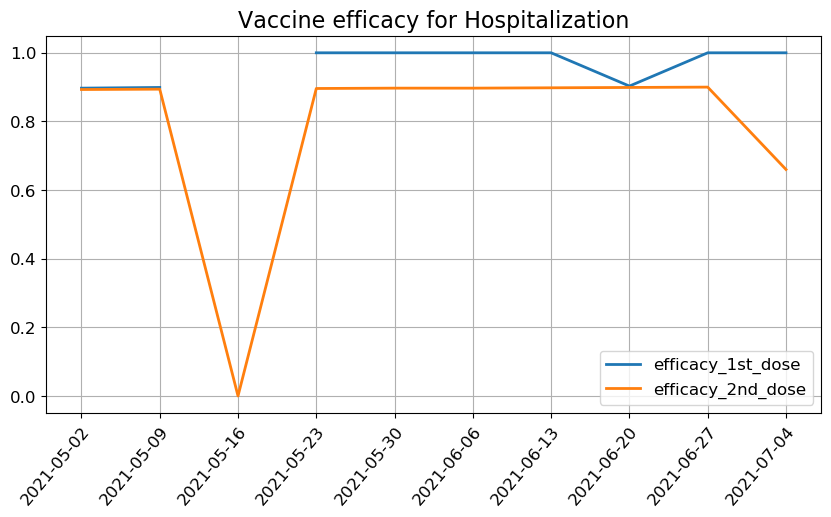

Event: Hospitalization
Age group: 70-79


/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


week  event_2nd_dose  event_no_vax  \
199  2021-06-13 - 2021-06-19             4.0           0.0   
200  2021-06-20 - 2021-06-26             4.0           4.0   
201  2021-06-27 - 2021-07-03             8.0           4.0   
202  2021-07-04 - 2021-07-10            16.0           4.0   

     ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
199                 0.857                 0.881              -0.000   
200                 0.000                 0.880             -83.910   
201                 0.000                 1.759             -76.089   
202                 0.854                 3.517             -66.722   

     efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
199                inf                inf                    NaN  
200              1.000              1.010                    NaN  
201              1.000              1.023                    NaN  
202              1.013              1.053                    NaN

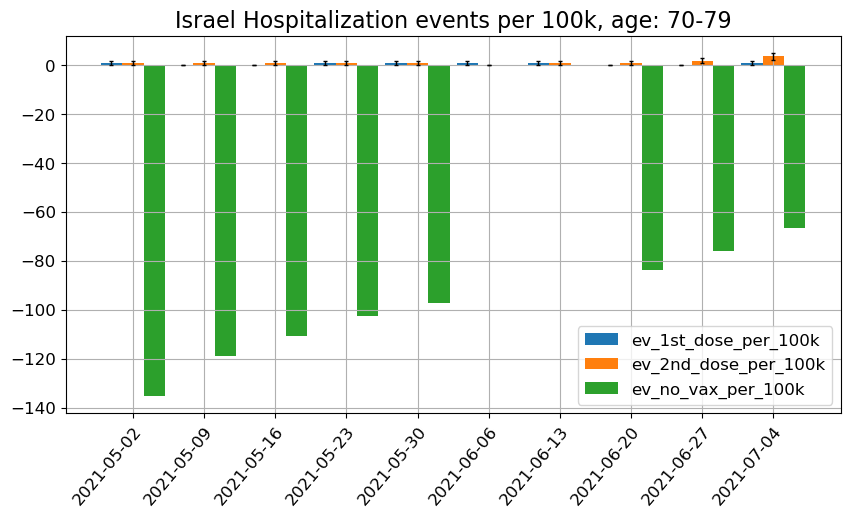

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


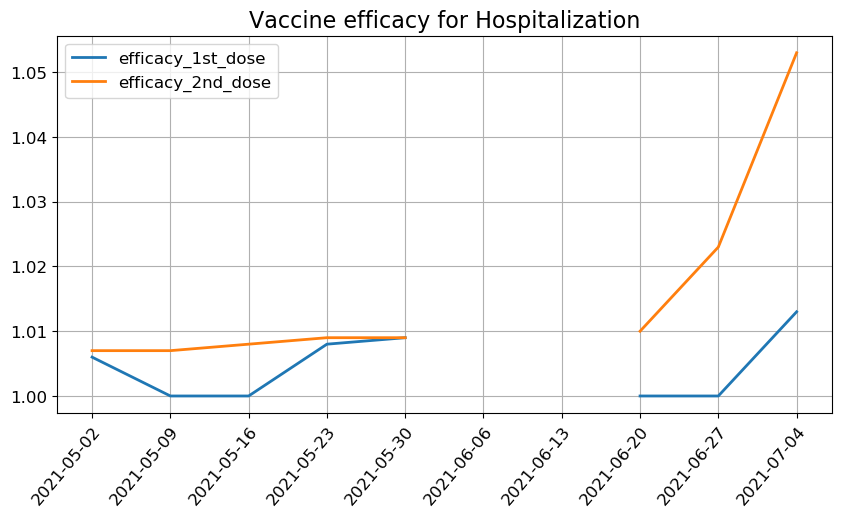

Event: Hospitalization
Age group: 80-89


week  event_2nd_dose  event_no_vax  \
228  2021-06-13 - 2021-06-19             4.0           0.0   
229  2021-06-20 - 2021-06-26             4.0           4.0   
230  2021-06-27 - 2021-07-03             9.0           4.0   
231  2021-07-04 - 2021-07-10             9.0           4.0   

     ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
228                   0.0                 1.949               0.000   
229                   0.0                 1.948              35.395   
230                   0.0                 4.380              36.255   
231                   0.0                 4.377              37.506   

     efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
228                NaN              0.000                    NaN  
229                1.0              0.945               2.921520  
230                1.0              0.879               1.570975  
231                1.0              0.883               1.579200

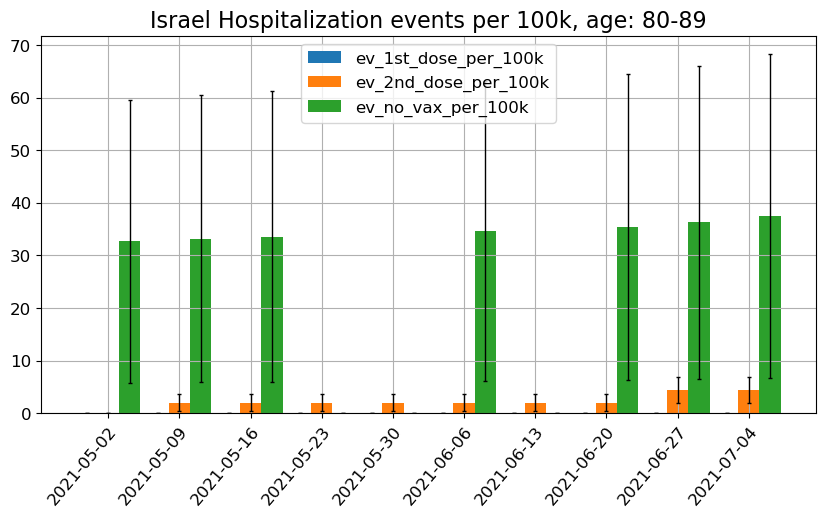

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


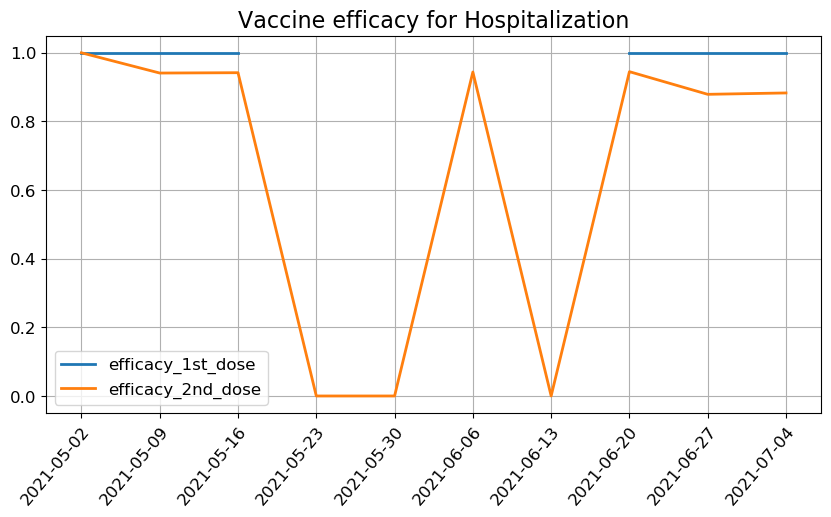

Event: Hospitalization
Age group: 90+


week  event_2nd_dose  event_no_vax  \
257  2021-06-13 - 2021-06-19             4.0           0.0   
258  2021-06-20 - 2021-06-26             0.0           4.0   
259  2021-06-27 - 2021-07-03             0.0           0.0   
260  2021-07-04 - 2021-07-10             4.0           0.0   

     ev_1st_dose_per_100k  ev_2nd_dose_per_100k  ev_no_vax_per_100k  \
257                   0.0                 8.626                0.00   
258                   0.0                 0.000              171.16   
259                   0.0                 0.000                0.00   
260                   0.0                 8.582                0.00   

     efficacy_1st_dose  efficacy_2nd_dose  err_efficacy_2nd_dose  
257                NaN                0.0                    NaN  
258                1.0                1.0                1.35219  
259                NaN                NaN                    NaN  
260                NaN                0.0                    NaN

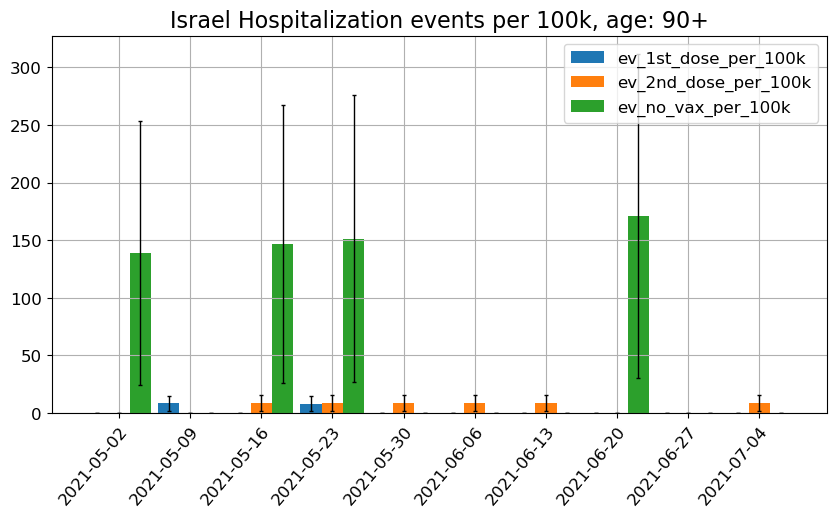

/Users/acastelli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/range.py:839: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return super().__getitem__(key)


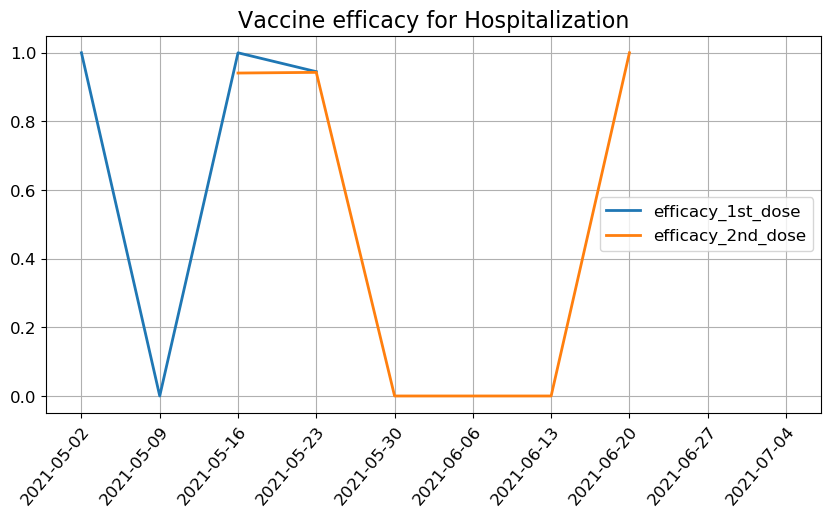

In [44]:
df_event_age_doses = {}
for event in ["Hospitalization"]:
    df_ages = {}
    for age in sorted(age_groups):
        print(f"Event: {event}")
        print(f"Age group: {age}")
        df_final = df_event_doses_pop[event][df_event_doses_pop[event]["age_group"] == age]
        df_final = df_final.sort_values(by=["first_day"])
        
        
        df_ages[age] = get_efficacy(df_final)
        
        display(df_final[["week",
                          "event_2nd_dose",
                          "event_no_vax",
                          "ev_1st_dose_per_100k",
                          "ev_2nd_dose_per_100k",
                          "ev_no_vax_per_100k",
                          "efficacy_1st_dose",
                          "efficacy_2nd_dose",
                          "err_efficacy_2nd_dose"]].tail(4))
        
        createXYPlot(df_final,
                     y=["ev_1st_dose_per_100k",
                        "ev_2nd_dose_per_100k",
                        "ev_no_vax_per_100k"],
                     error=True,
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2021-05-01",
                     days_interval=1,
                     bar=True,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Israel {event} events per 100k, age: {age}",
                     savename=f"Israel_{event}_events_per_100k_{age}"
            )
        
        createXYPlot(df_final,
                     y=["efficacy_1st_dose",
                        "efficacy_2nd_dose"],
                     error=False,
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2021-05-01",
                     days_interval=1,
                     bar=False,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=f"Vaccine efficacy for {event}",
                     savename=f"Efficacy_{event}_{age}"
            )
        
    
    df_event_age_doses[event] = df_ages
    

In [71]:
df_eff_list = []
for key in df_event_age_doses["Hospitalization"].keys():
    df_eff = df_event_age_doses["Hospitalization"][key][df_event_age_doses["Hospitalization"][key]["last_day"] == last_day]
    df_eff = df_eff[["age_group","week","efficacy_2nd_dose"]]
    df_eff_list.append(df_eff)

In [74]:
df_eff_final = pd.concat(df_eff_list).reset_index(drop=True)

In [75]:
df_eff_final

age_group                     week  efficacy_2nd_dose
0      0-19  2021-07-04 - 2021-07-10             -6.054
1     20-29  2021-07-04 - 2021-07-10              0.724
2     30-39  2021-07-04 - 2021-07-10              0.789
3     40-49  2021-07-04 - 2021-07-10              0.847
4     50-59  2021-07-04 - 2021-07-10              0.899
5     60-69  2021-07-04 - 2021-07-10              0.660
6     70-79  2021-07-04 - 2021-07-10              1.053
7     80-89  2021-07-04 - 2021-07-10              0.883
8       90+  2021-07-04 - 2021-07-10              0.000

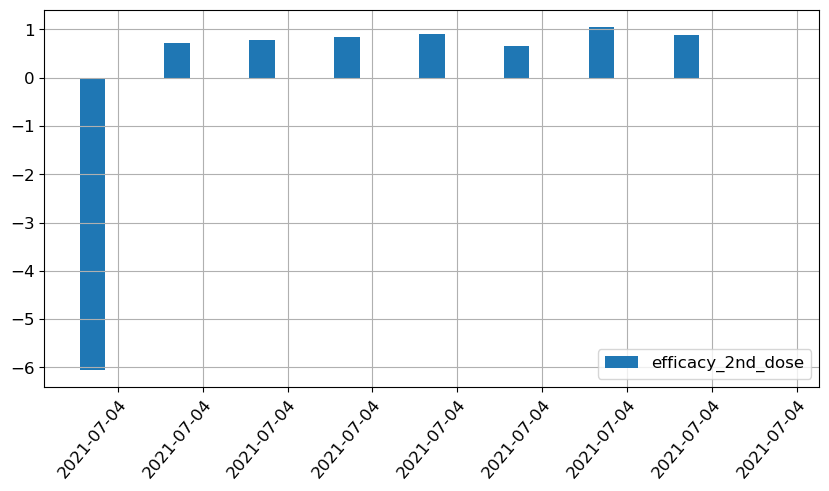

In [65]:
createXYPlot(df_eff_final,
                     y=["efficacy_2nd_dose"],
                     error=False,
                     today="",
                     plots_folder=plot_folder,
                     x="first_day",
                     linewidth=2,
                     start_date="2021-05-01",
                     days_interval=1,
                     bar=True,
                     alpha=1,
                     bar_width=0.3,
                     bar_start=[-1,0,1],
                     title=None,
                     savename=None
            )